In [1]:
#the code pipeline for the feature extraction for respiratory methods are highly similar with few differences
#below, we show how to extract features for one participant using the thorax RIP raw data


# FEATURE EXTRACTION EXAMPLE FOR THORAX RIP OF A PARTICIPANT

In [2]:
import pandas as pd
#we first read in a data set of one participant as an example
#it contains the raw Thorax RIP data (already inverted around the x axis so the increases represent inspiration)
#it also contains a column called Task_Label_2 which includes our task labels for the procedure

#data can also be read in from other formats as long as it is turned into a pandas dataframe format

#the dataframe should not be datetime indexed. if it is, drop the indexes before following with the next 
import pandas as pd

# read the HDF5 file into a DataFrame
df_thorax = pd.read_hdf('df_thorax.h5', 'df_thorax')

df_thorax


RSP_Raw Task_Label_2
0       -2.393300e+10             
1       -2.393163e+10             
2       -2.393300e+10             
3       -2.393376e+10             
4       -2.393300e+10             
...               ...          ...
1059836 -2.402300e+10         94.0
1059837 -2.402598e+10         94.0
1059838 -2.402300e+10         94.0
1059839 -2.401202e+10         94.0
1059840 -2.402300e+10         94.0

[1059841 rows x 2 columns]

In [3]:
#below, we are customizing the steps of respiration processing and defining the function via neurokit2
#the main steps include cleaning and identification of troughs and peaks
def my_cleaning(rsp_signal, sampling_rate):
    # My custom cleaning logic
    cleaned = nk.signal_filter(
        rsp_signal,
        sampling_rate=sampling_rate,
        lowcut=0.05,
        highcut=0.60,
        order=2,
        method='butterworth'
    )
    return cleaned

import pandas as pd

from neurokit2 import as_vector
from neurokit2 import signal_rate
from neurokit2 import rsp_amplitude
from neurokit2 import rsp_clean
from neurokit2 import rsp_methods
from neurokit2 import rsp_peaks
from neurokit2 import rsp_phase
from neurokit2 import rsp_plot
from neurokit2 import rsp_rvt
from neurokit2 import rsp_symmetry

def my_process_hexoskin(
    rsp_signal,
    sampling_rate=256,
    method="scipy",
    method_rvt="harrison2021",
    report=None,
    **kwargs
):
    """**Process a respiration (RSP) signal**

    Convenience function that automatically processes a respiration signal with one of the
    following methods:

    * `Khodadad et al. (2018) <https://iopscience.iop.org/article/10.1088/1361-6579/aad7e6/meta>`_

    * `BioSPPy <https://github.com/PIA-Group/BioSPPy/blob/master/biosppy/signals/resp.py>`_

    Parameters
    ----------
    rsp_signal : Union[list, np.array, pd.Series]
        The raw respiration channel (as measured, for instance, by a respiration belt).
    sampling_rate : int
        The sampling frequency of :func:`.rsp_signal` (in Hz, i.e., samples/second).
    method : str
        The processing pipeline to apply. Can be one of ``"khodadad2018"`` (default)
        or ``"biosppy"``.
    method_rvt : str
        The rvt method to apply. Can be one of ``"harrison2021"`` (default), ``"birn2006"``
        or ``"power2020"``.
    report : str
        The filename of a report containing description and figures of processing
        (e.g. ``"myreport.html"``). Needs to be supplied if a report file
        should be generated. Defaults to ``None``. Can also be ``"text"`` to
        just print the text in the console without saving anything.
    **kwargs
        Other arguments to be passed to specific methods. For more information,
        see :func:`.rsp_methods`.

    Returns
    -------
    signals : DataFrame
        A DataFrame of same length as :func:`.rsp_signal` containing the following columns:

        * ``"RSP_Raw"``: the raw signal.
        * ``"RSP_Clean"``: the cleaned signal.
        * ``"RSP_Peaks"``: the respiratory peaks (exhalation onsets) marked as "1" in a list of
          zeros.
        * ``"RSP_Troughs"``: the respiratory troughs (inhalation onsets) marked as "1" in a list of
          zeros.
        * ``"RSP_Rate"``: breathing rate interpolated between inhalation peaks.
        * ``"RSP_Amplitude"``: breathing amplitude interpolated between inhalation peaks.
        * ``"RSP_Phase"``: breathing phase, marked by "1" for inspiration and "0" for expiration.
        * ``"RSP_PhaseCompletion"``: breathing phase completion, expressed in percentage (from 0 to
          1), representing the stage of the current respiratory phase.
         * ``"RSP_RVT"``: respiratory volume per time (RVT).
    info : dict
        A dictionary containing the samples at which inhalation peaks and exhalation troughs occur,
        accessible with the keys ``"RSP_Peaks"``, and ``"RSP_Troughs"`` respectively, as well as the
        signals' sampling rate.

    See Also
    --------
    rsp_clean, rsp_findpeaks, .signal_rate, rsp_amplitude, rsp_plot, rsp_phase, rsp_rvt, rsp_symmetry

    Examples
    --------
    .. ipython:: python

      import neurokit2 as nk

      rsp = nk.rsp_simulate(duration=90, respiratory_rate=15)
      signals, info = nk.rsp_process(rsp, sampling_rate=250, report="text")

      @savefig p_rsp_process_1.png scale=100%
      fig = nk.rsp_plot(signals, sampling_rate=250)
      @suppress
      plt.close()

    """
    # sanitize input
    rsp_signal = as_vector(rsp_signal)
    methods = rsp_methods(
        sampling_rate=sampling_rate, method=method, method_rvt=method_rvt, **kwargs
    )

    # clean signal
    rsp_cleaned = my_cleaning(rsp_signal, sampling_rate=sampling_rate)

    # extract, fix and format peaks
    peak_signal, info = rsp_peaks(
        rsp_cleaned,
        sampling_rate=sampling_rate,
        method=methods["method_peaks"],
        peak_distance=1.65, 
        **methods["kwargs_peaks"]
    )
    
    info["sampling_rate"] = sampling_rate  # Add sampling rate in dict info

    # getting additional parameters
    phase = rsp_phase(peak_signal, desired_length=len(rsp_signal))
    amplitude = rsp_amplitude(rsp_cleaned, peak_signal)
    rate = signal_rate(
        info["RSP_Troughs"], sampling_rate=sampling_rate, desired_length=len(rsp_signal)
    )
    symmetry = rsp_symmetry(rsp_cleaned, peak_signal)
    rvt = rsp_rvt(
        rsp_cleaned,
        method=methods["method_rvt"],
        sampling_rate=sampling_rate,
        silent=True,
    )

    # preparing output
    signals = pd.DataFrame(
        {
            "RSP_Raw": rsp_signal,
            "RSP_Clean": rsp_cleaned,
            "RSP_Amplitude": amplitude,
            "RSP_Rate": rate,
            "RSP_RVT": rvt,
        }
    )
    signals = pd.concat([signals, phase, symmetry, peak_signal], axis=1)

    if report is not None:
       
        if ".html" in str(report):
            fig = rsp_plot(signals, sampling_rate=sampling_rate)
        else:
            fig = None
        create_report(file=report, signals=signals, info=methods, fig=fig)

    return signals, info


In [4]:
#below, we define a function which will, for each of the task names we enter, clean the segments of interest and do
#peak trough detection within the 30-sec segment entered along with the 5 seconds before and after each segment
#it creates a new dataframe per segment with RSP_Raw (stays same), RSP_Cleaned, and RSP_Peaks, RSP_Troughs
#Whenever there is a peak, RSP_Peaks = 1, and whenever there is a trough, RSP_Troughs = 1

#the function also visualizes the cleaned segments with the peak and troughs
participant_id = 58682 #this changes for each participant, needed only for the visualizations (is on the title of each graph)

def process_and_visualize(results_hexoskin, tasks):
    hexoskin_data = df_thorax
    tasks_dataframes = {}

    # Segmenting the dataframe into task-specific dataframes
    for task in tasks:
        task_indices = hexoskin_data[hexoskin_data['Task_Label_2'] == task].index

        if not task_indices.empty:
            start_index = task_indices[0] - 1280
            end_index = task_indices[-1] + 1280
            start_index = max(start_index, 0)
            end_index = min(end_index, len(hexoskin_data) - 1)
            task_dataframe = hexoskin_data.loc[start_index:end_index, ['RSP_Raw', 'Task_Label_2']]
            tasks_dataframes[task] = task_dataframe

    # processing each task-specific dataframe
    processed_tasks_dataframes = {}
    for task, task_df in tasks_dataframes.items():
        rsp_signal = task_df['RSP_Raw']
        processed_data, _ = my_process_hexoskin(rsp_signal, sampling_rate=256)
        processed_data.reset_index(drop=True, inplace=True)
        task_df_reset = task_df.reset_index(drop=True)
        processed_data_with_label = processed_data.merge(task_df_reset[['Task_Label_2']], left_index=True, right_index=True, how='left')
        processed_tasks_dataframes[task] = processed_data_with_label

    # visualizing the actual task portions - portions of interest
    for task, df in processed_tasks_dataframes.items():
        task_specific_indices = df.index[df['Task_Label_2'] == task]
        if not task_specific_indices.empty:
            task_start = task_specific_indices[0]
            task_end = task_specific_indices[-1]

            plt.figure(figsize=(15, 4))
            plt.plot(df.loc[task_start:task_end, 'RSP_Clean'], label='RSP_Clean', color='black')
            peaks = df.loc[task_start:task_end][df['RSP_Peaks'] == 1].index
            troughs = df.loc[task_start:task_end][df['RSP_Troughs'] == 1].index

            for peak in peaks:
                plt.axvline(x=peak, color='red', linestyle='--', alpha=0.7)
            for trough in troughs:
                plt.axvline(x=trough, color='blue', linestyle='--', alpha=0.7)

            plt.title(f"Participant {participant_id}, Task: {task}")
            plt.xlabel("Samples")
            plt.ylabel("RSP_Clean")
            plt.legend()
            plt.show()
    
    return processed_tasks_dataframes


C:\Users\msa583\AppData\Local\Temp\ipykernel_3424\1947522911.py:44: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  peaks = df.loc[task_start:task_end][df['RSP_Peaks'] == 1].index
C:\Users\msa583\AppData\Local\Temp\ipykernel_3424\1947522911.py:45: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  troughs = df.loc[task_start:task_end][df['RSP_Troughs'] == 1].index


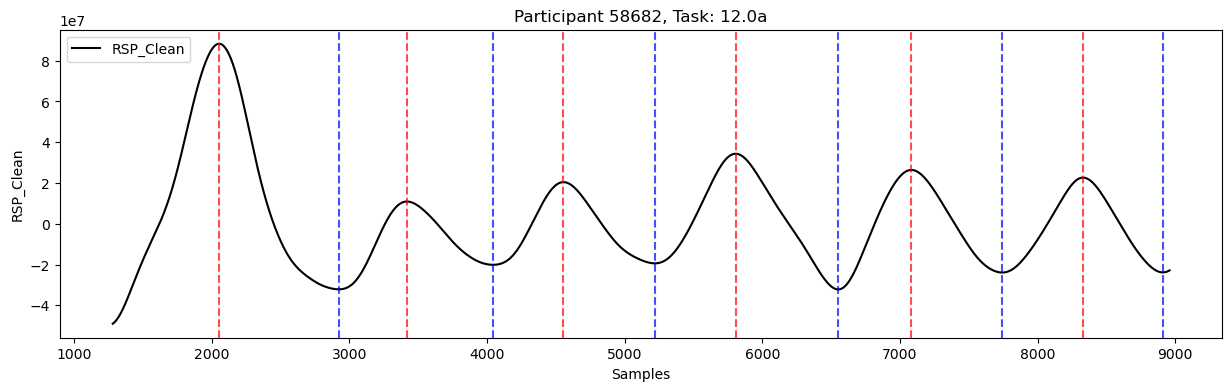

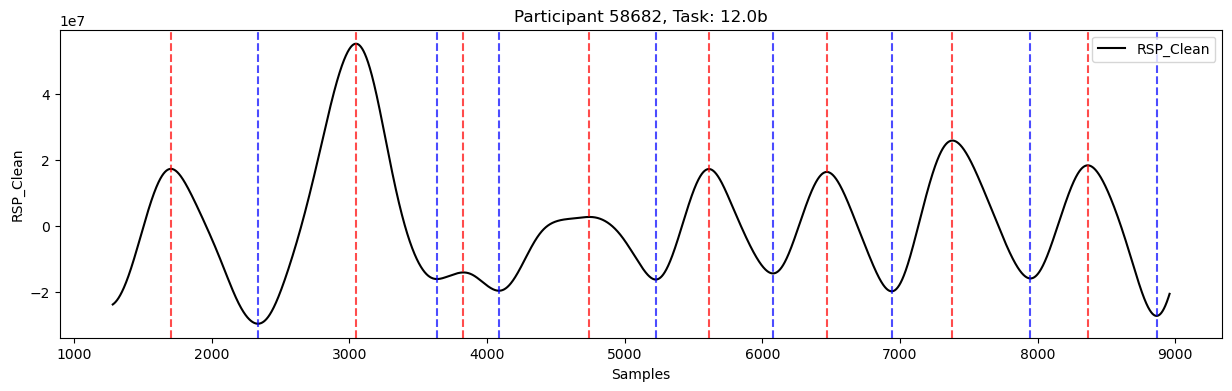

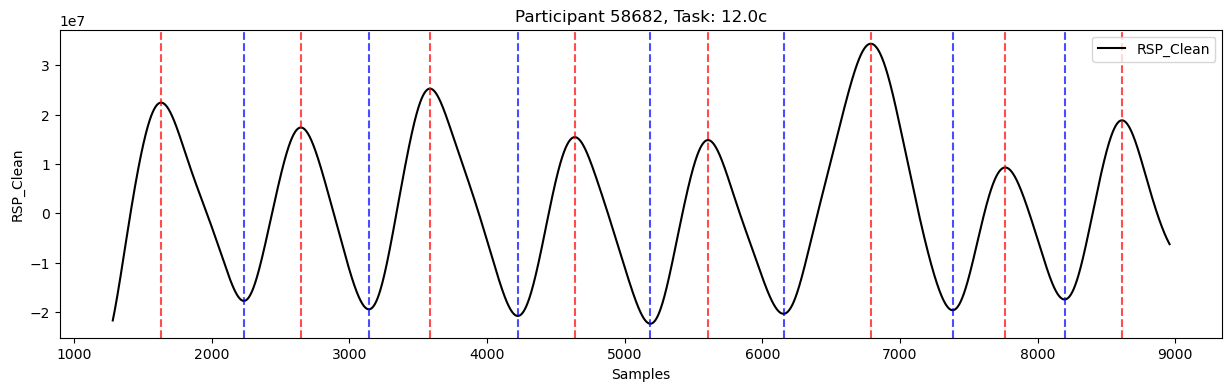

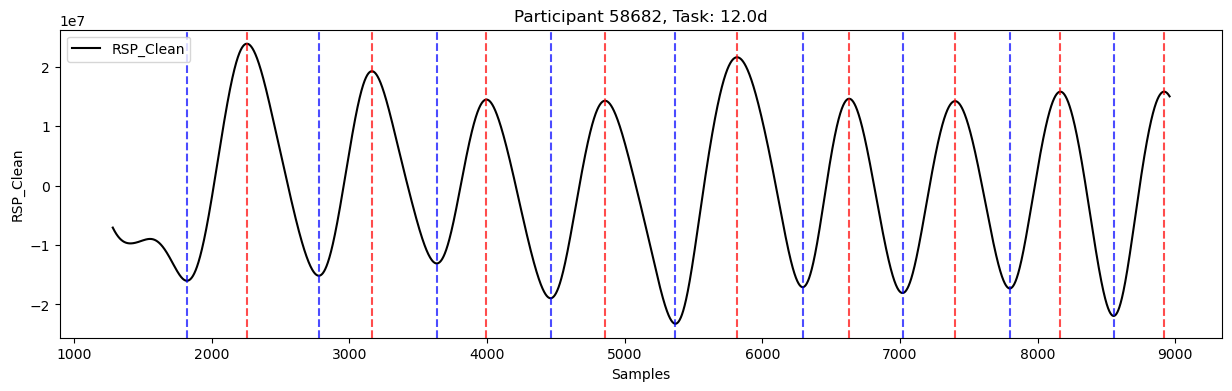

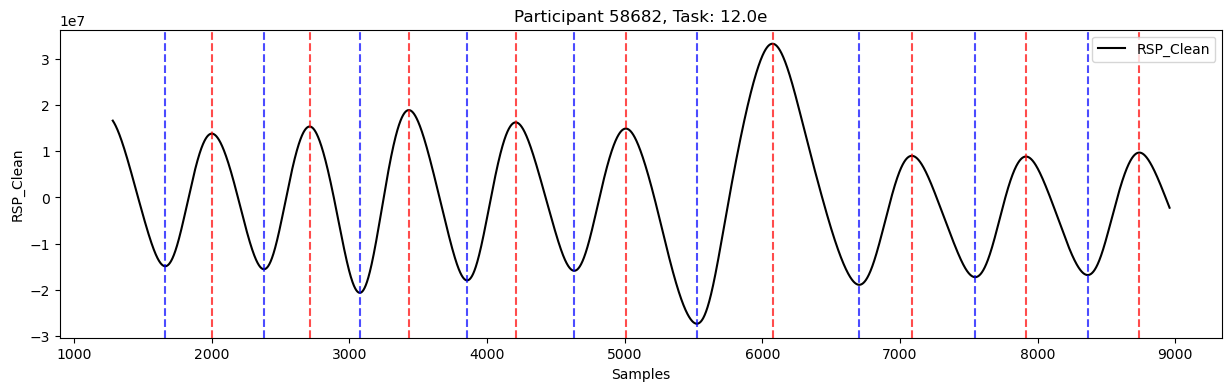

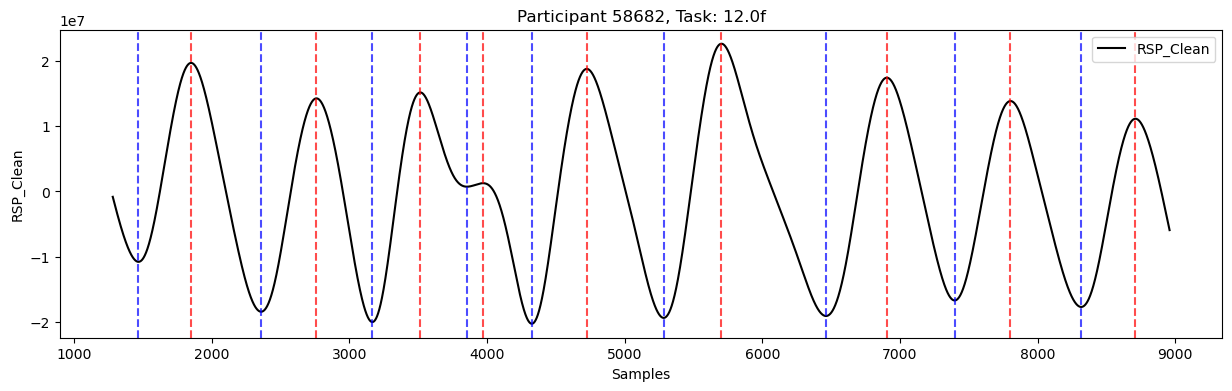

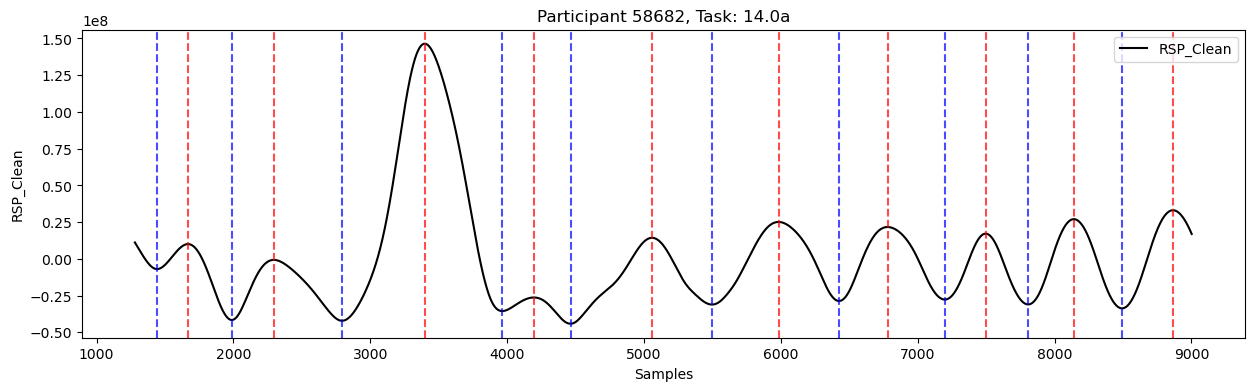

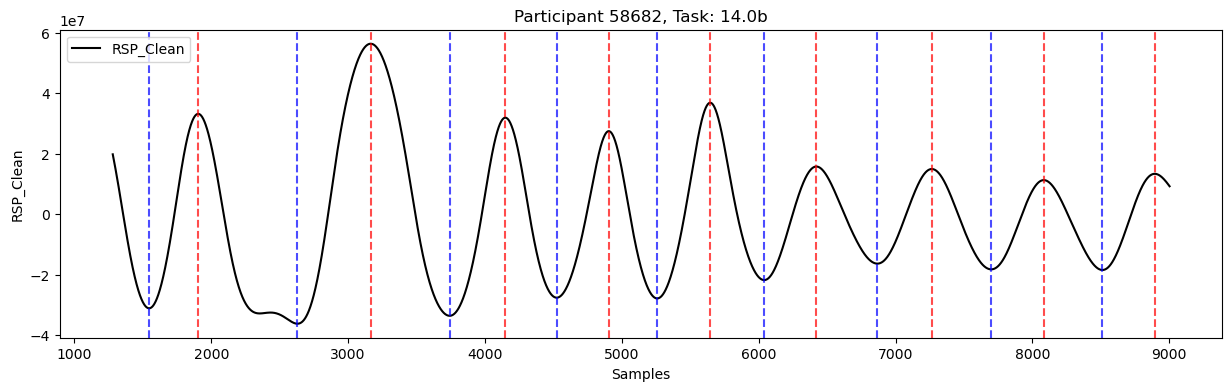

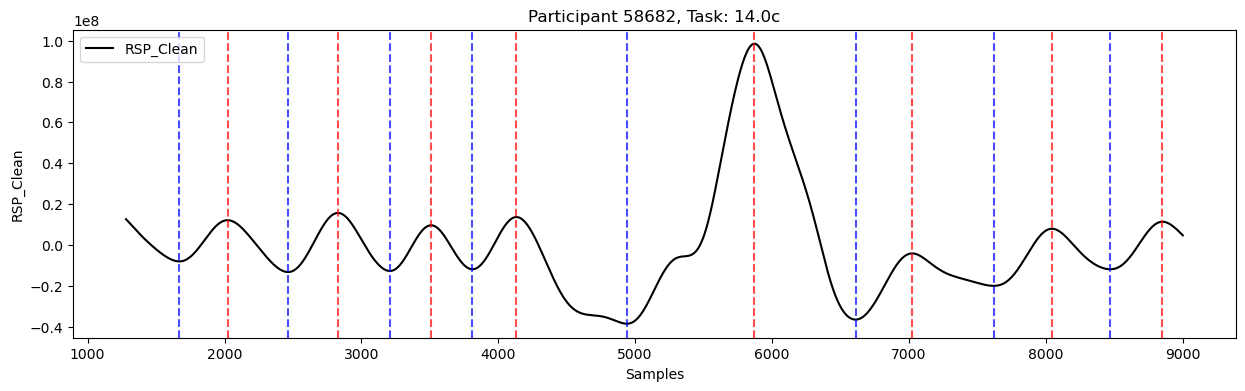

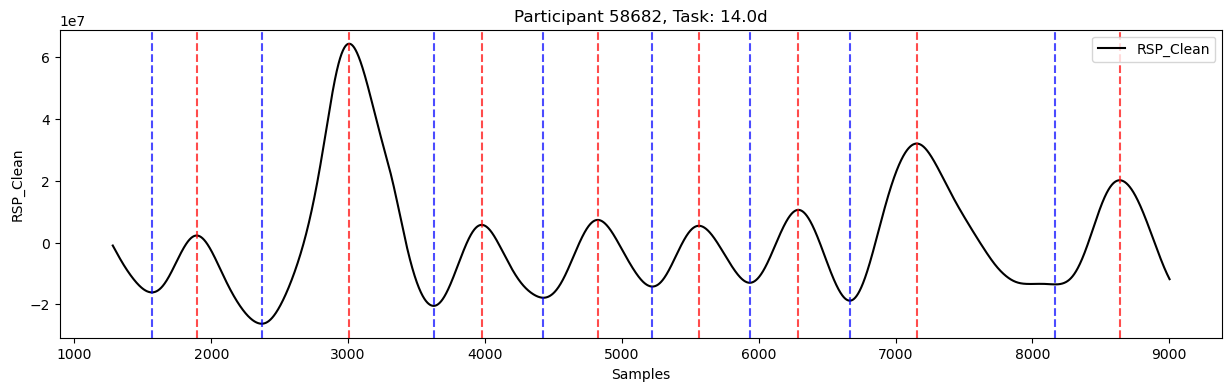

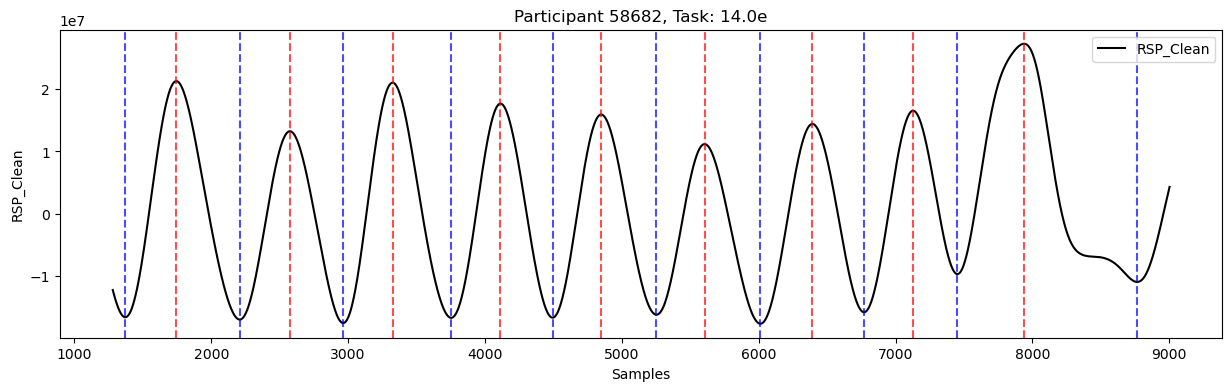

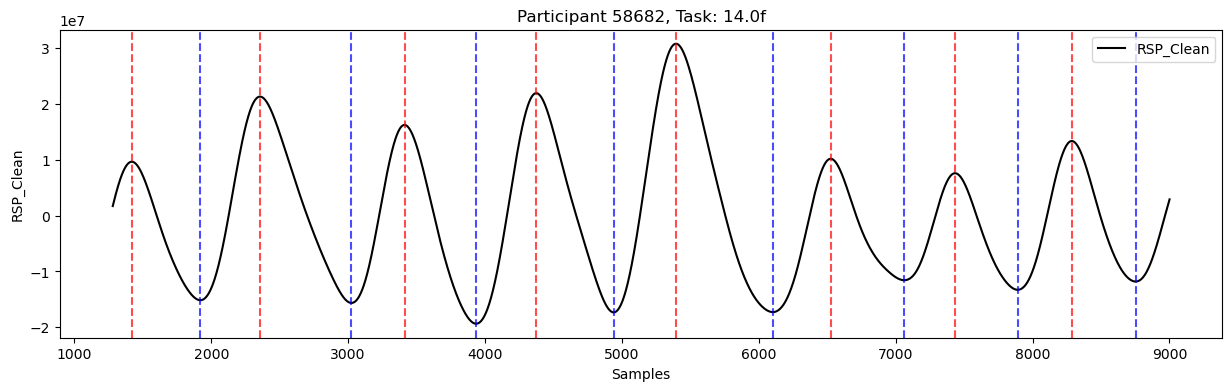

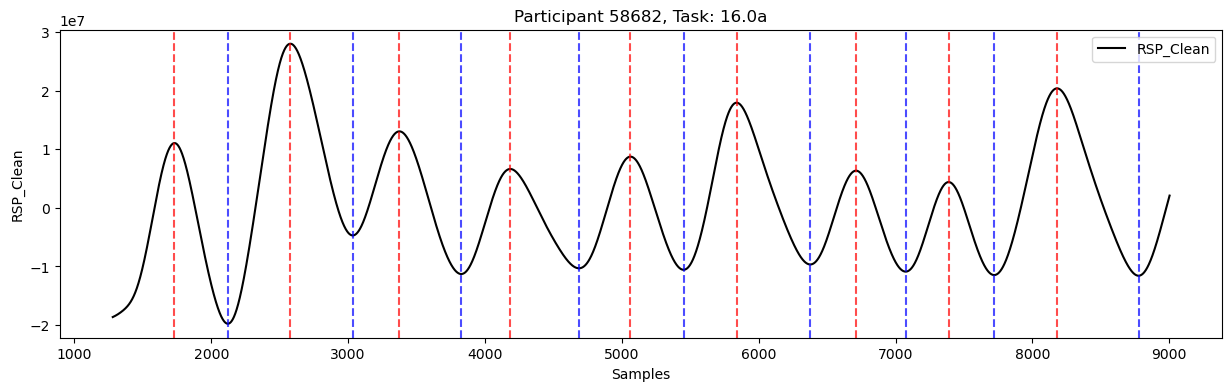

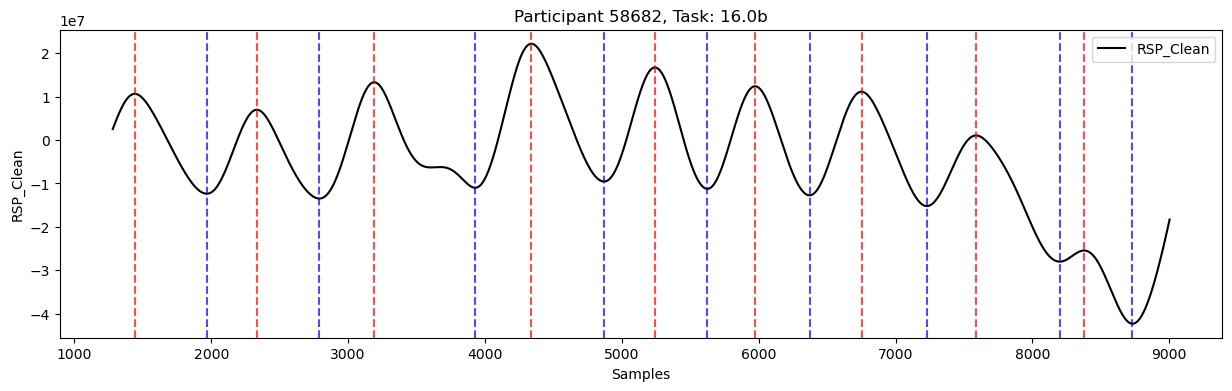

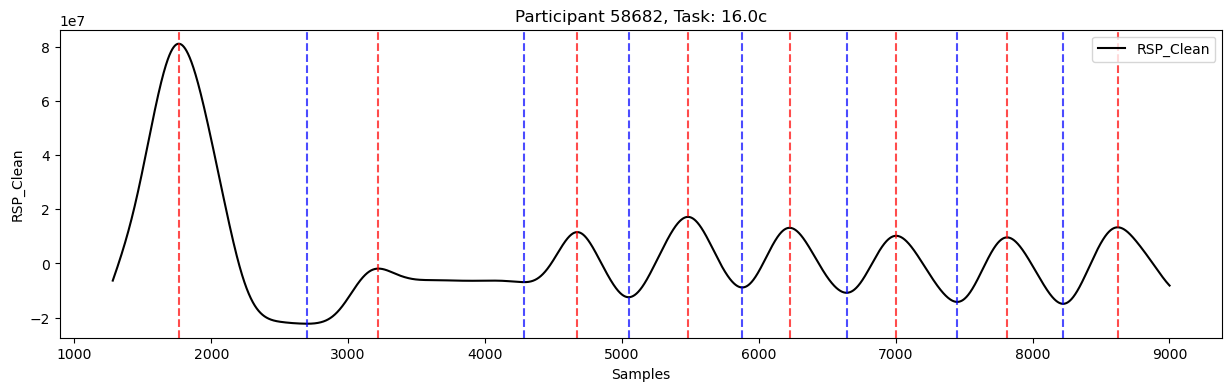

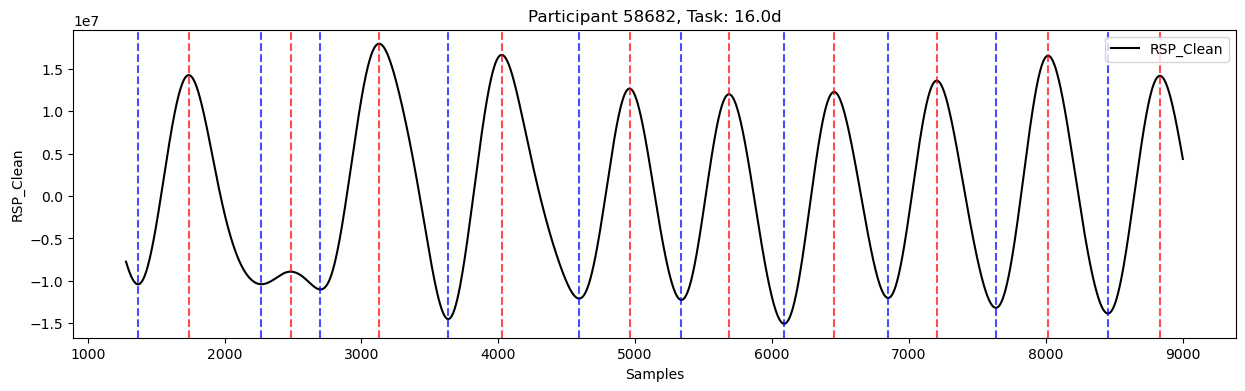

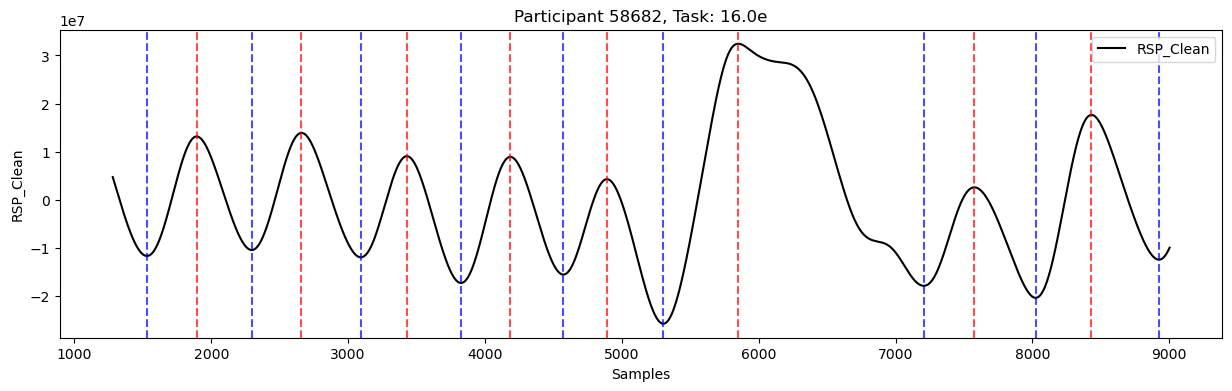

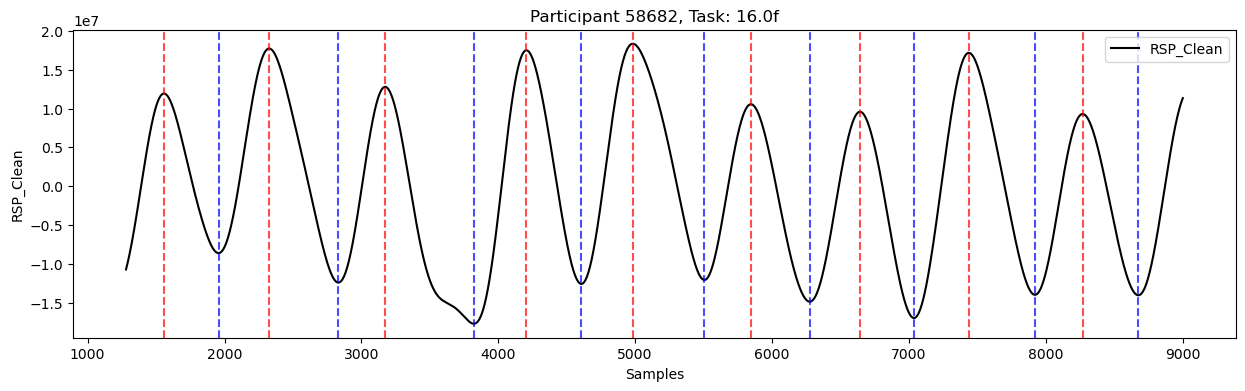

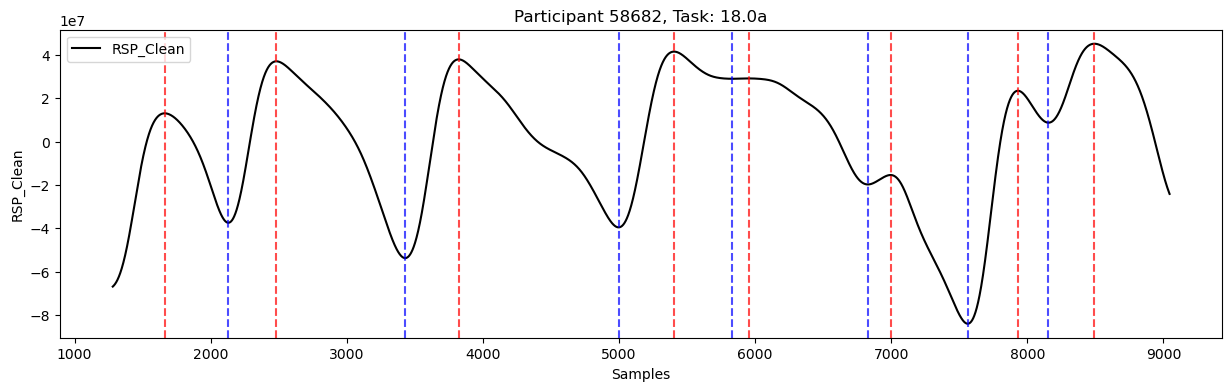

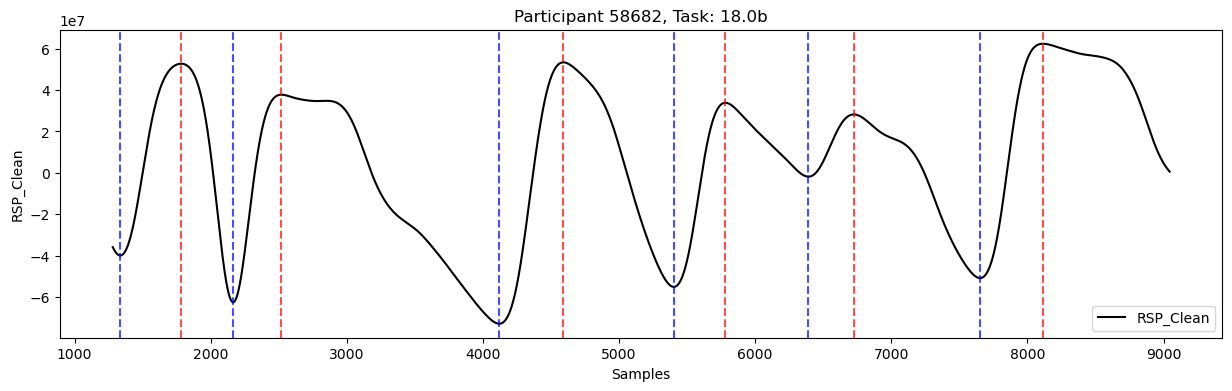

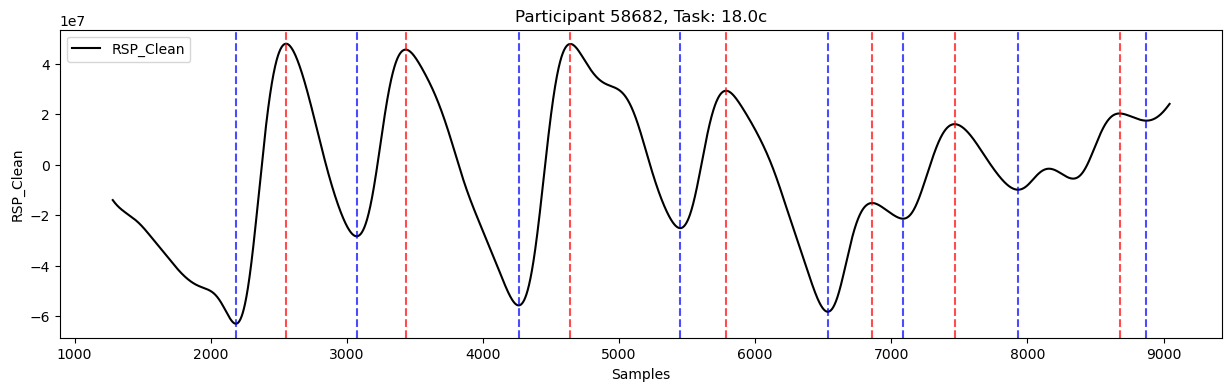

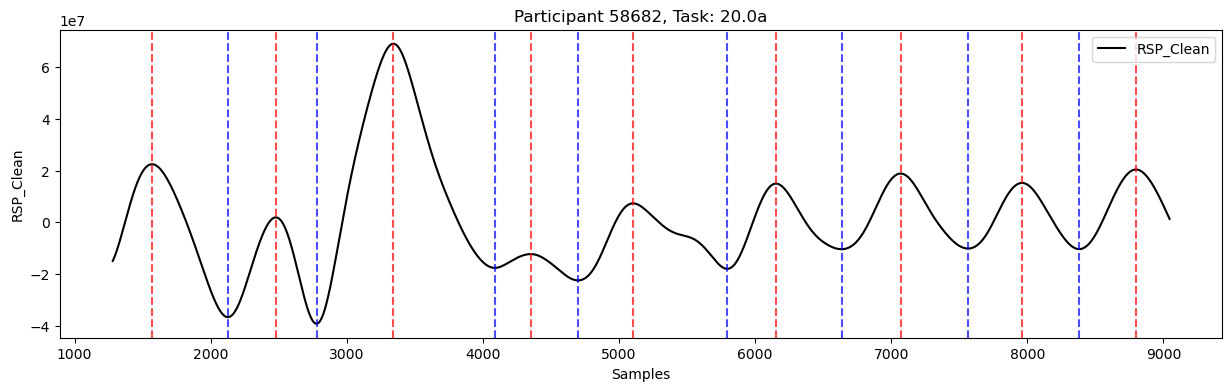

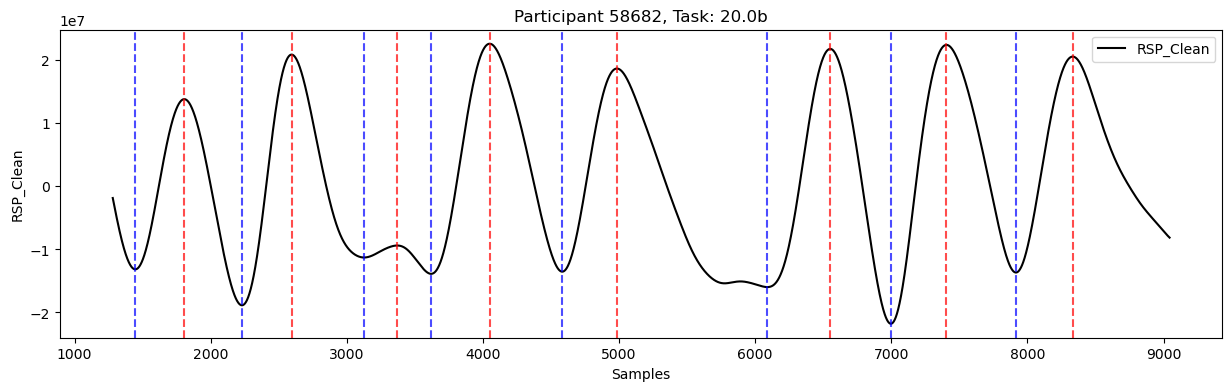

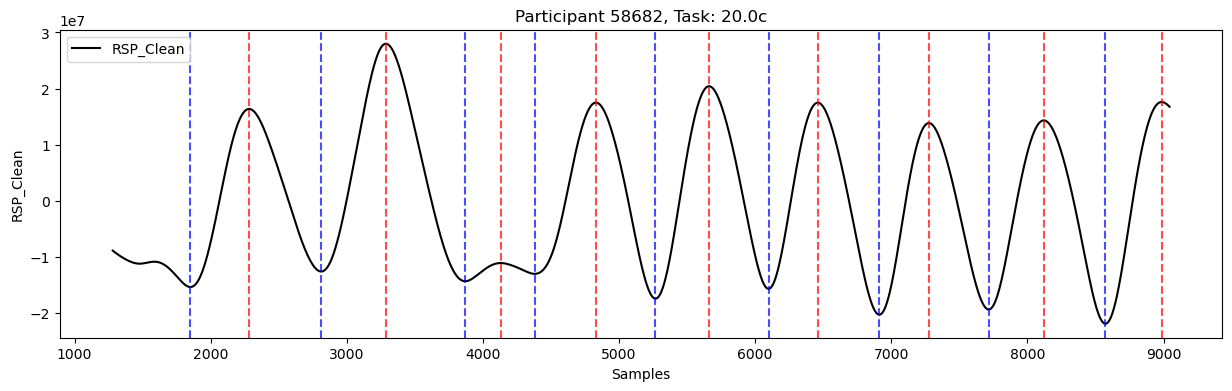

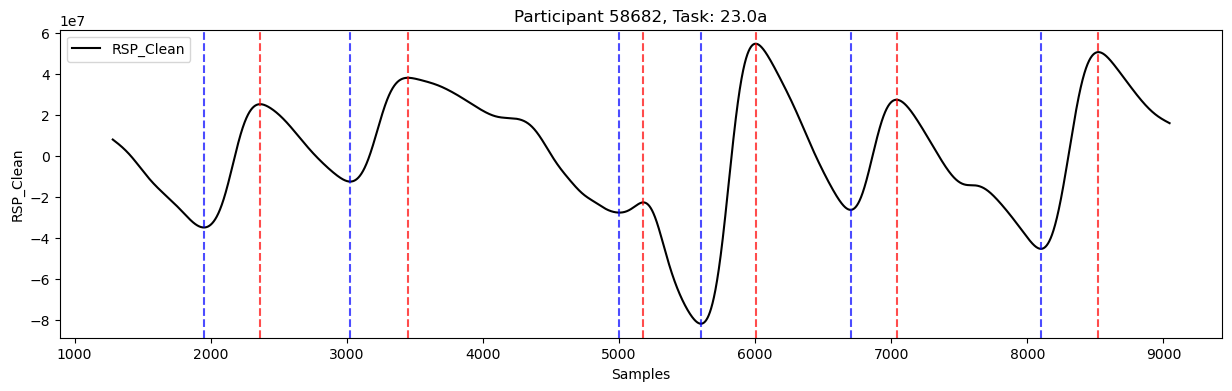

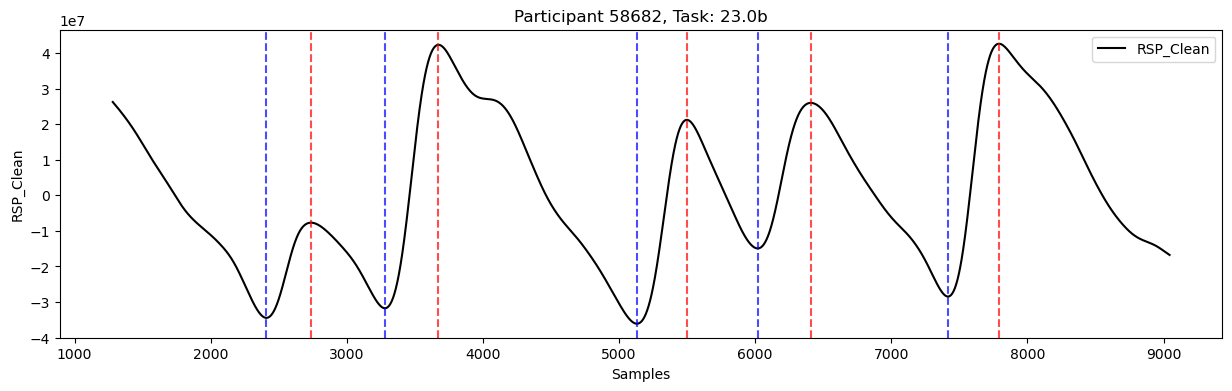

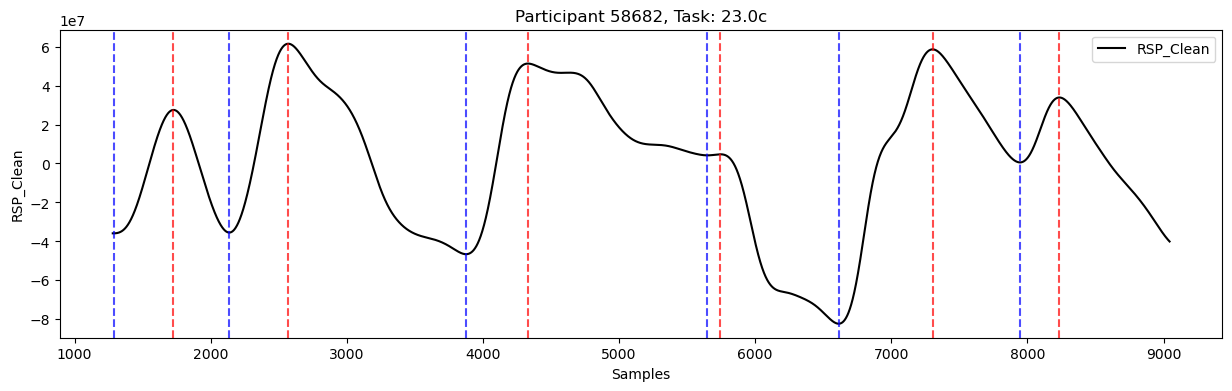

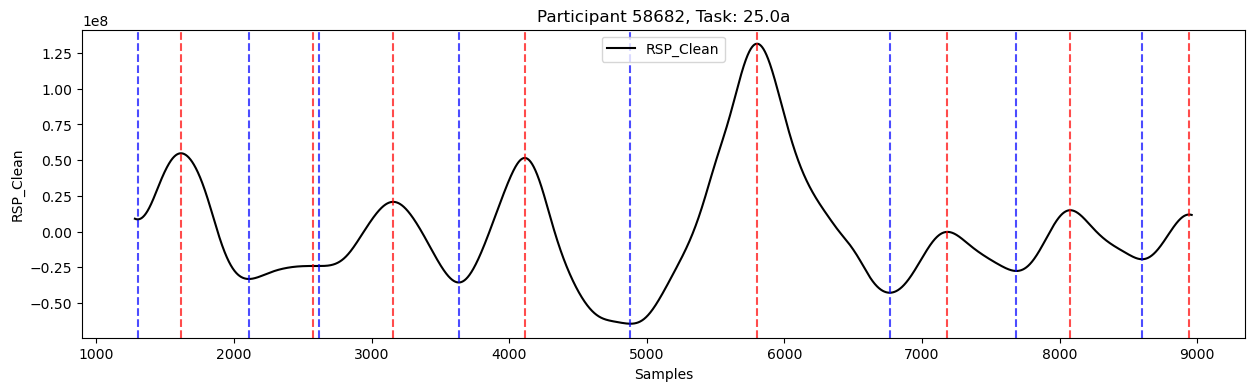

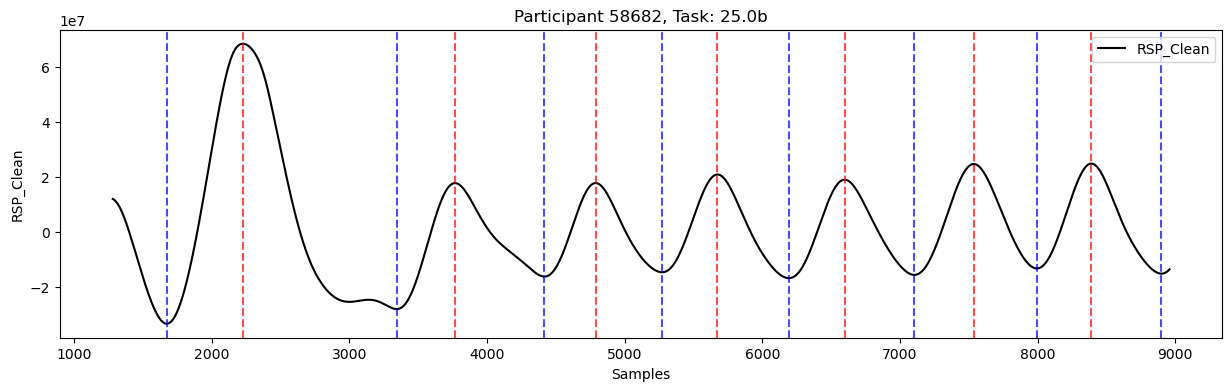

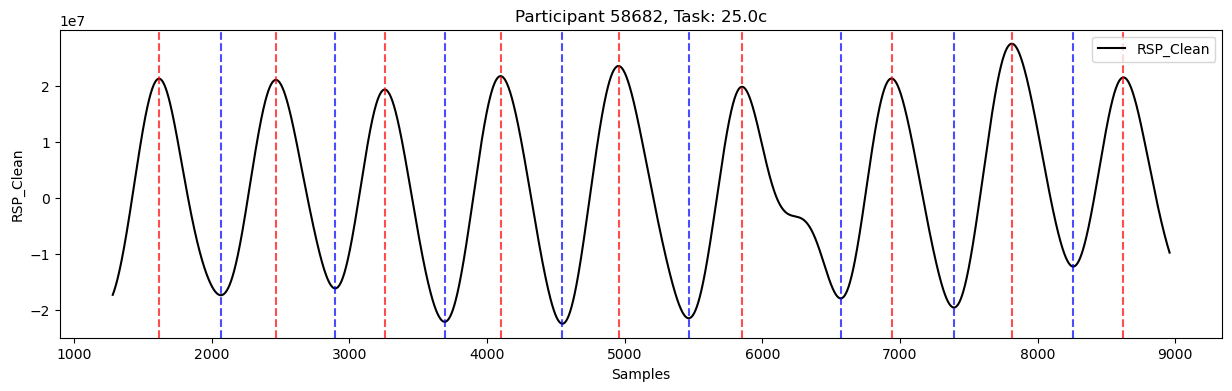

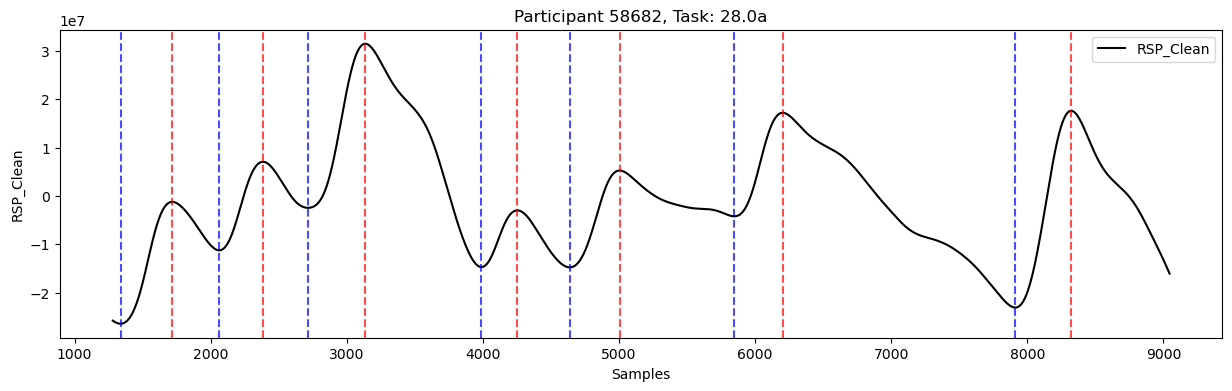

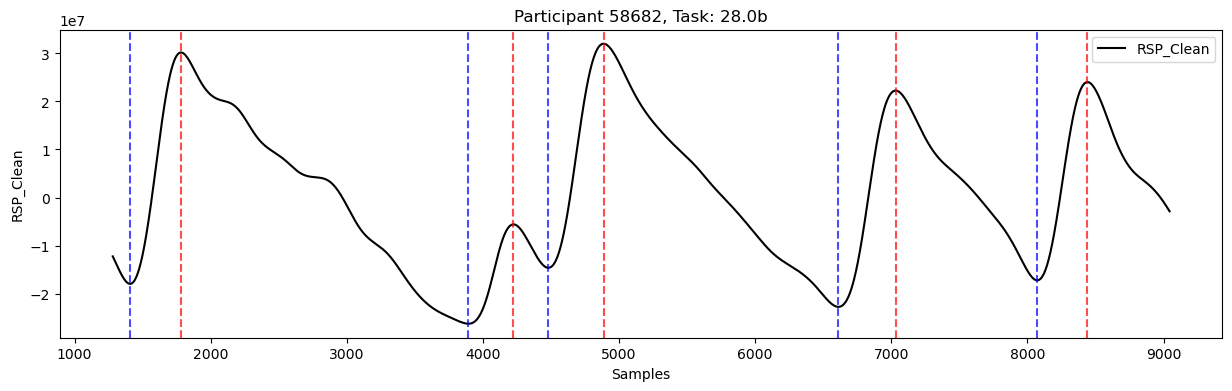

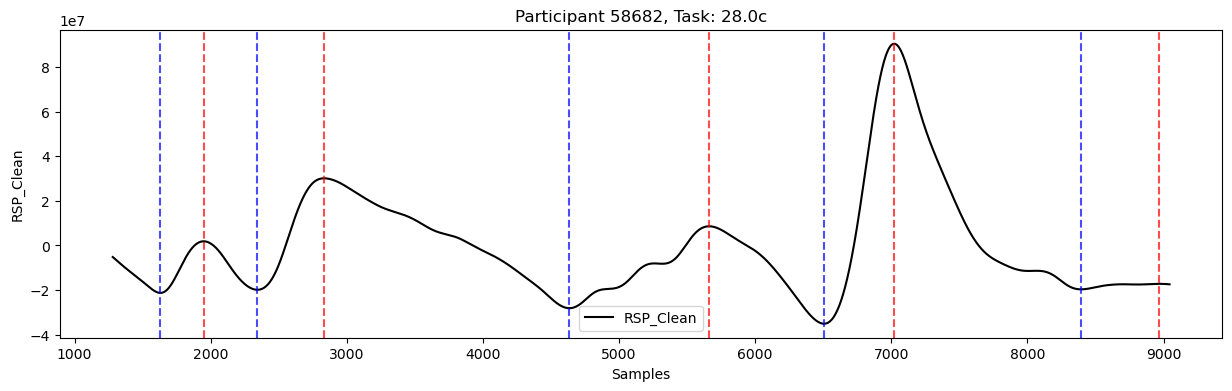

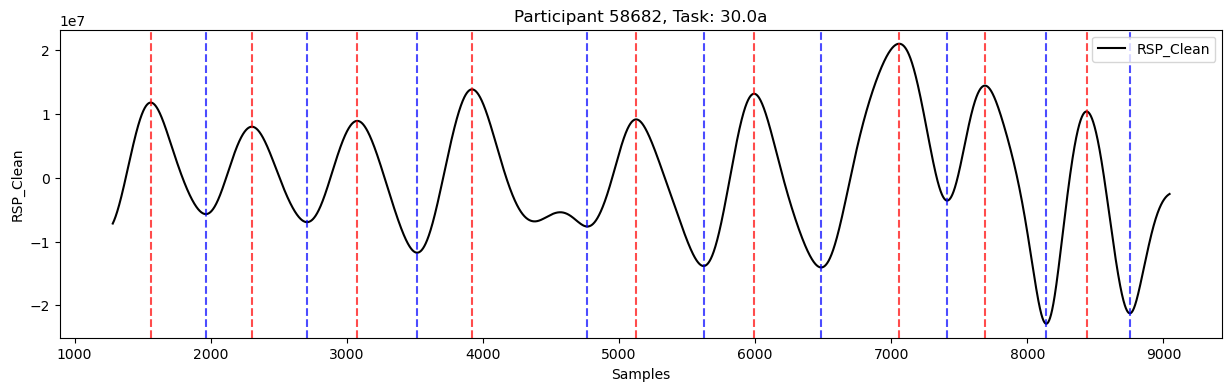

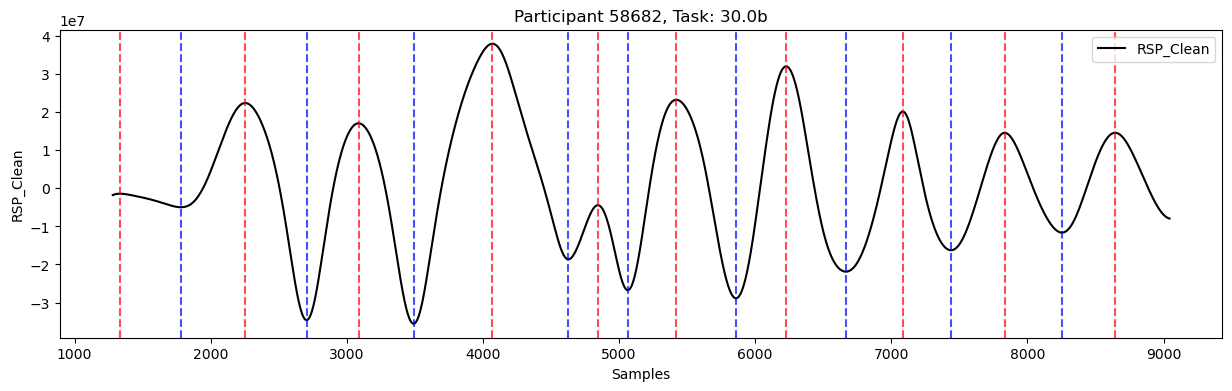

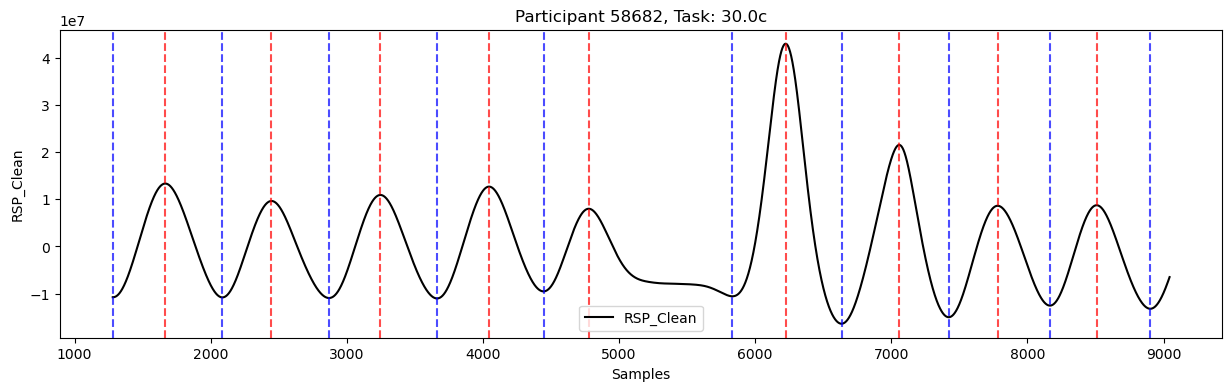

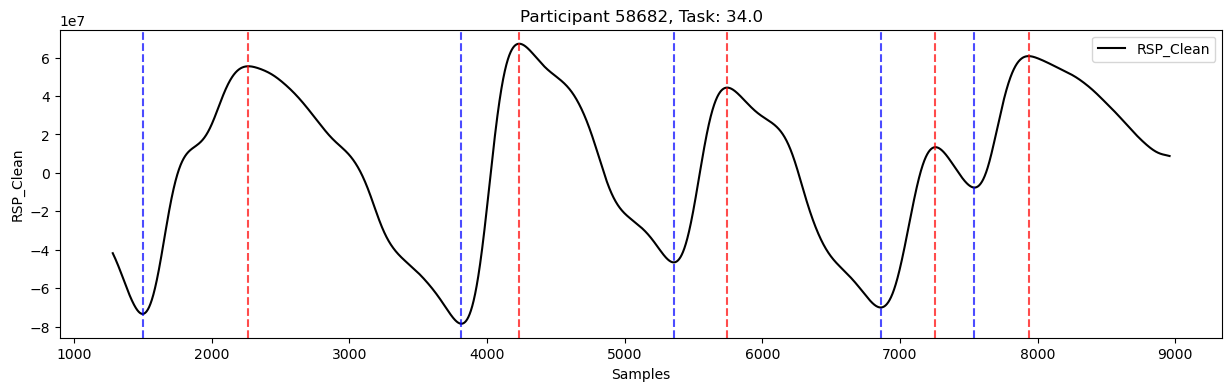

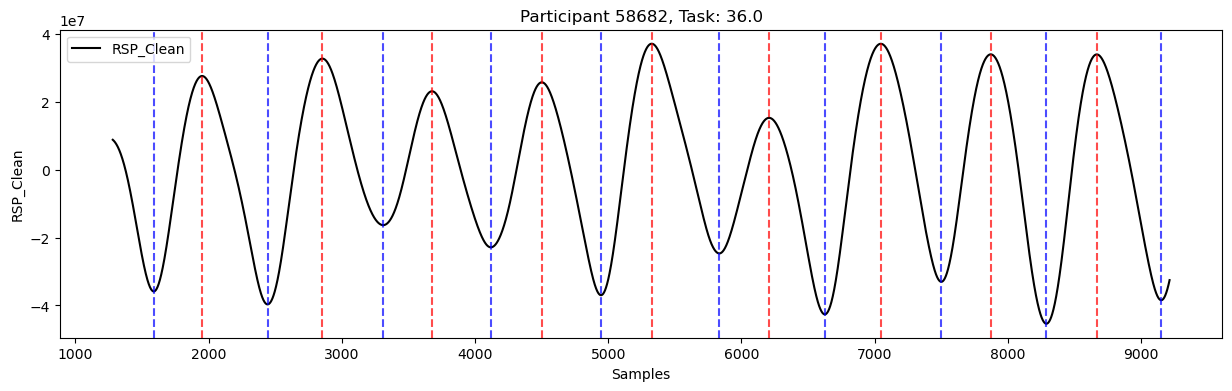

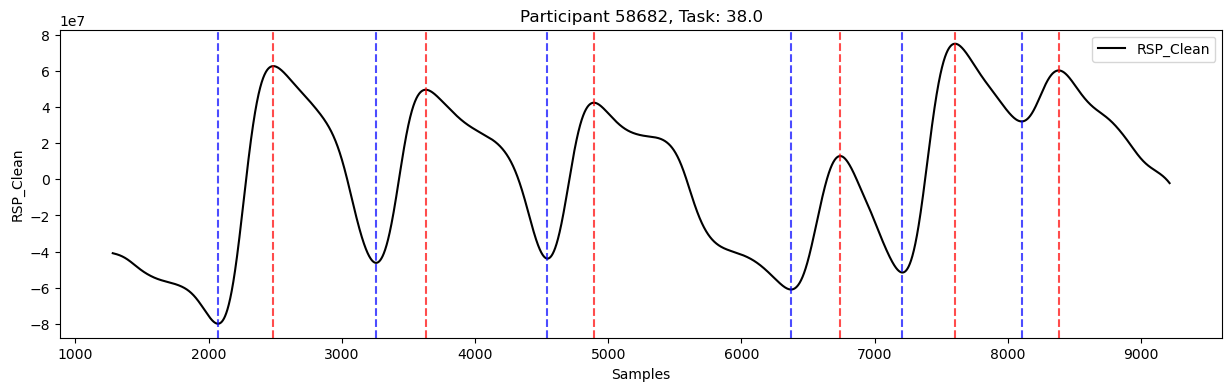

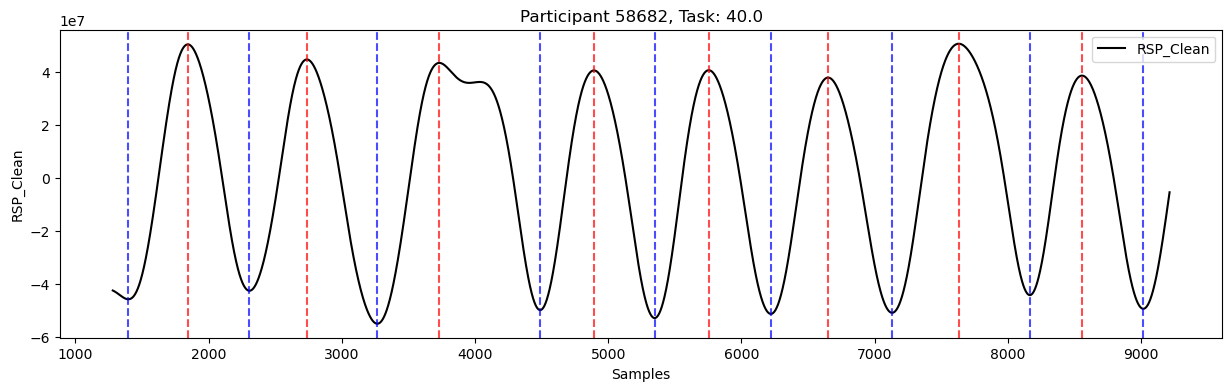

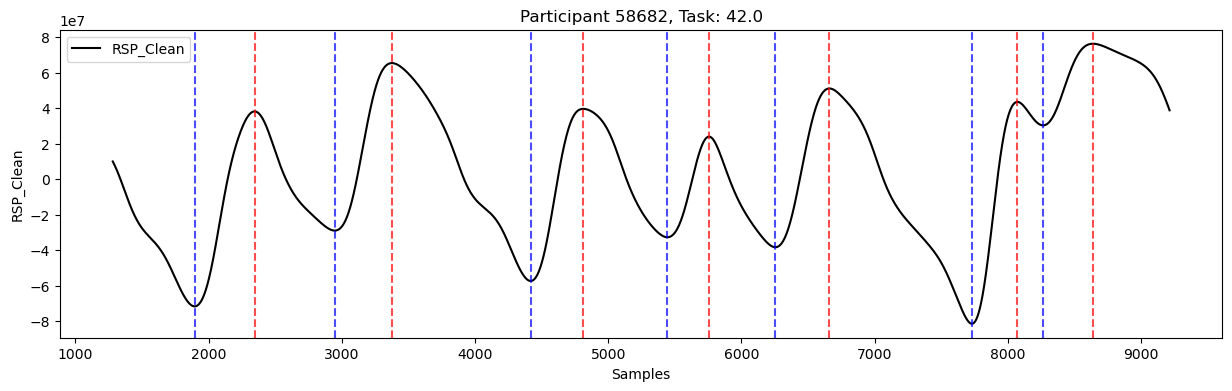

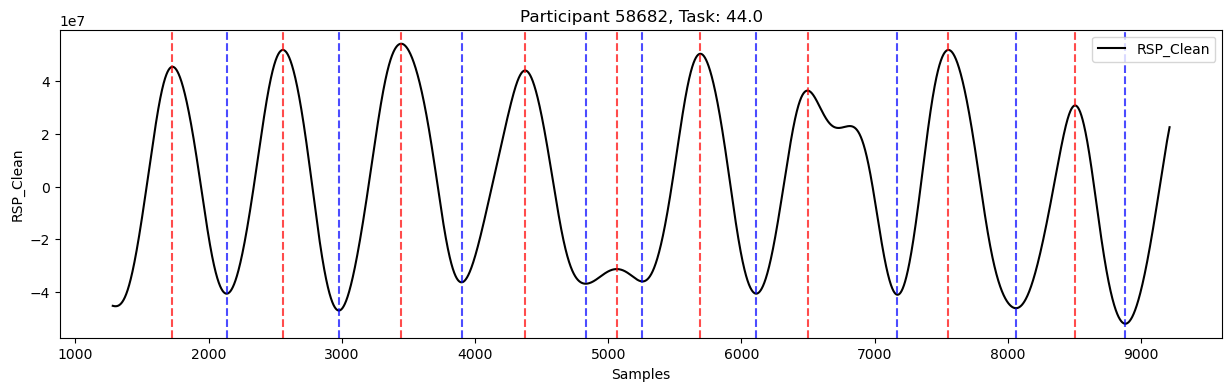

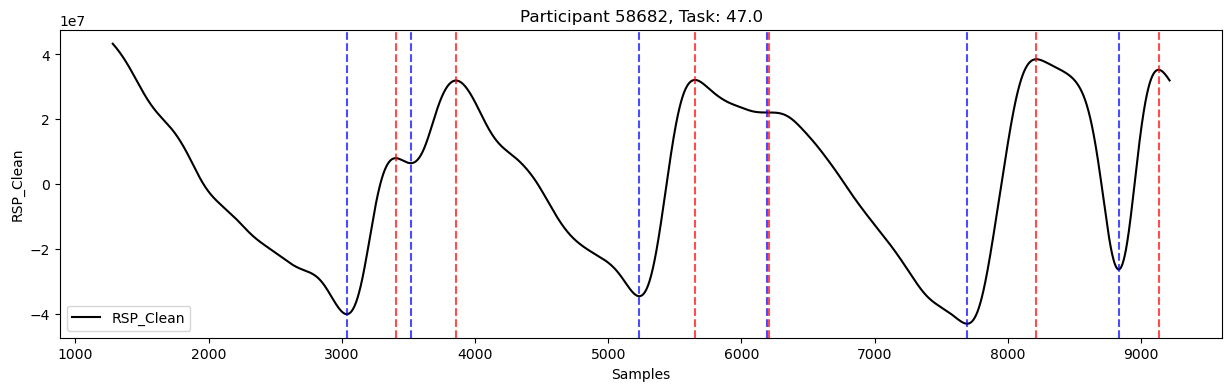

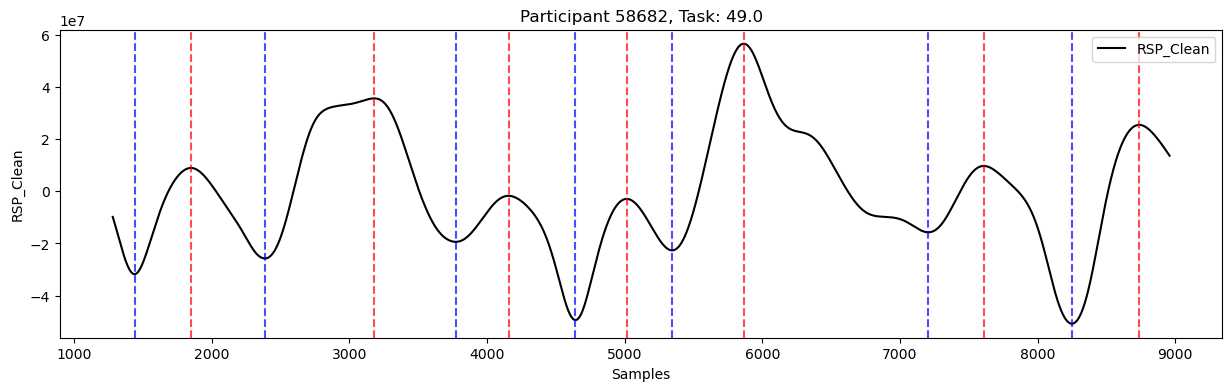

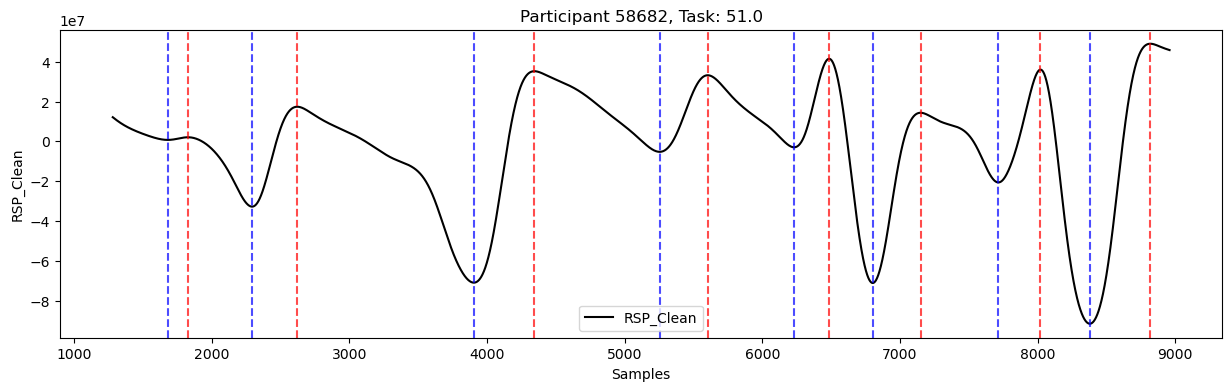

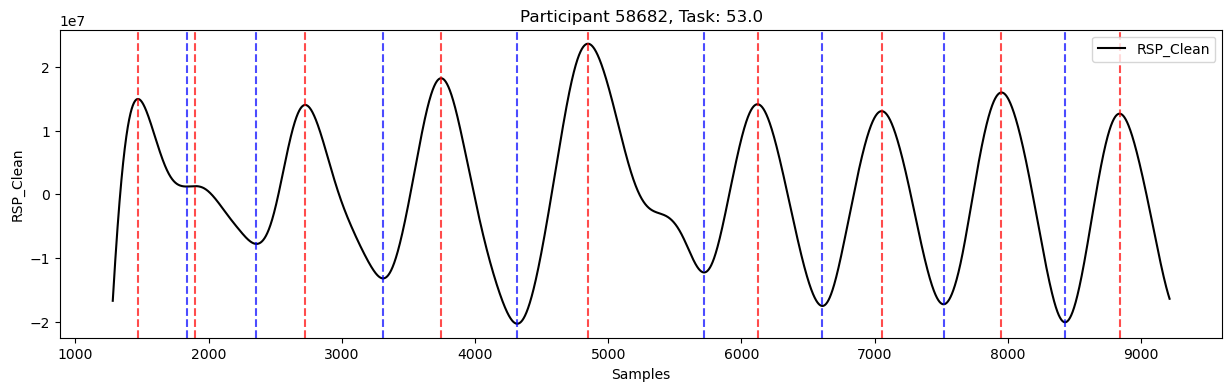

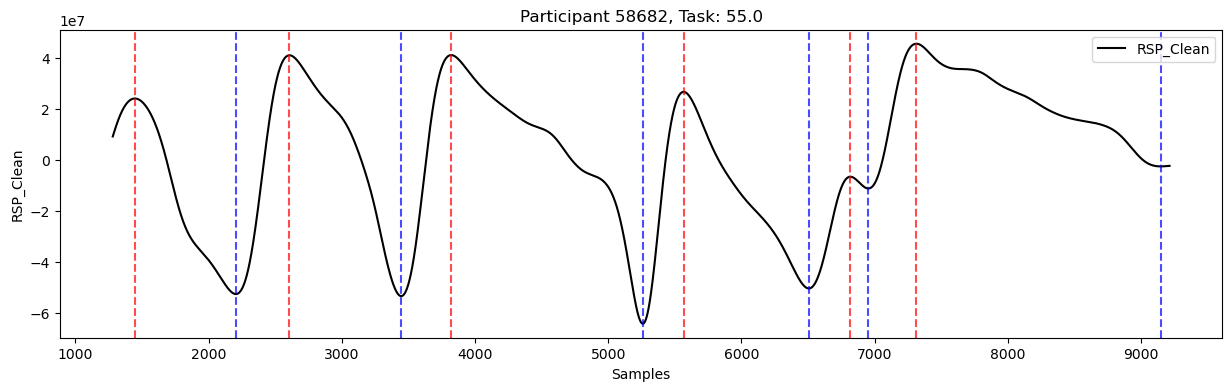

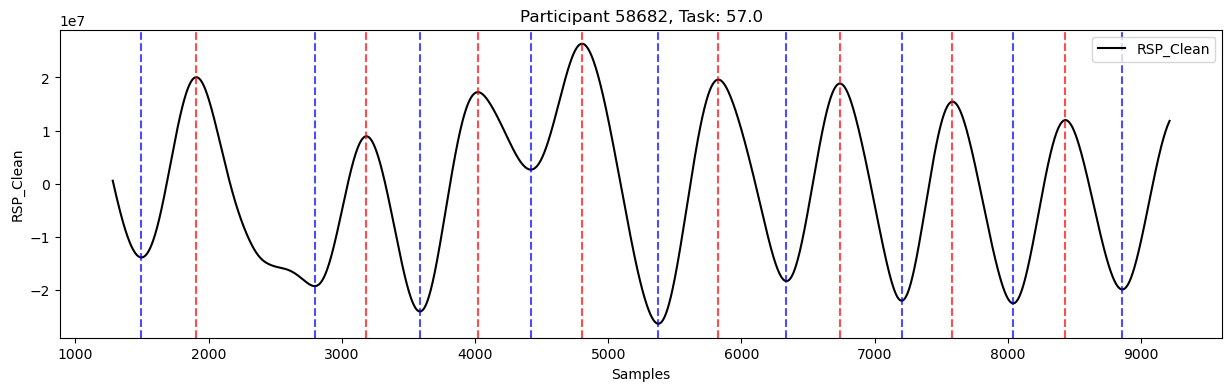

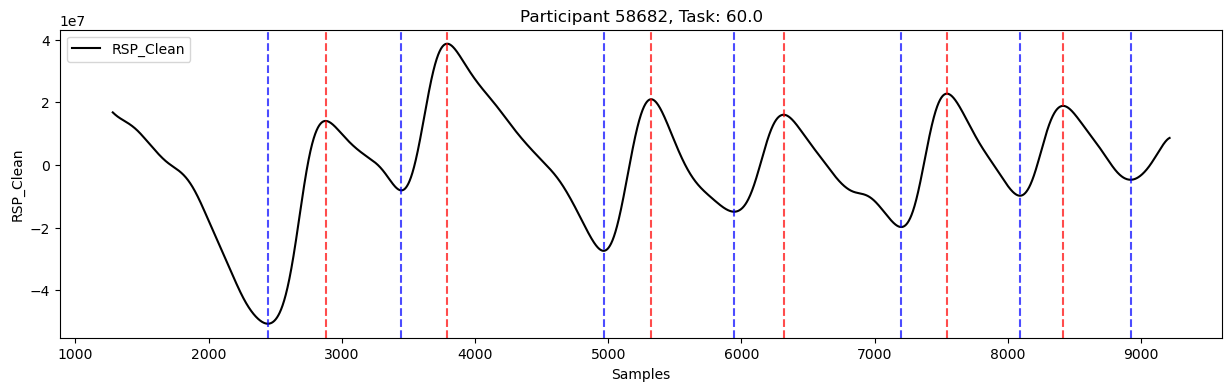

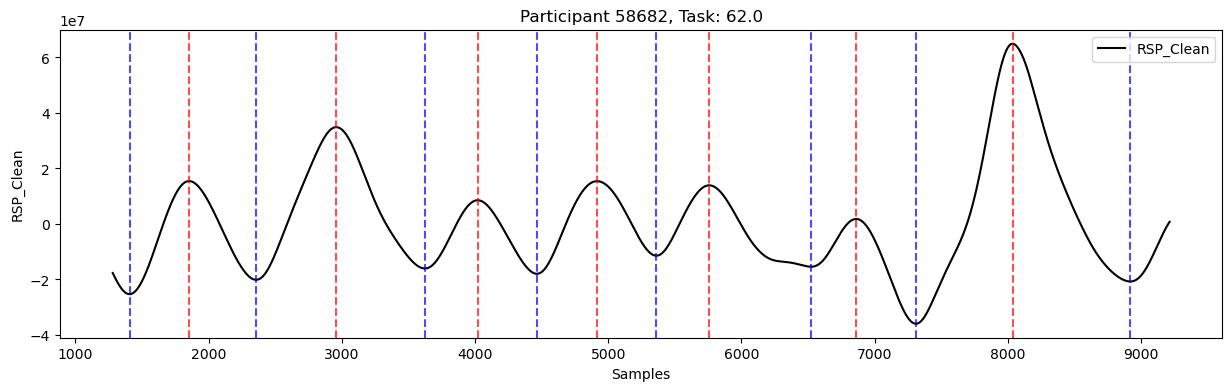

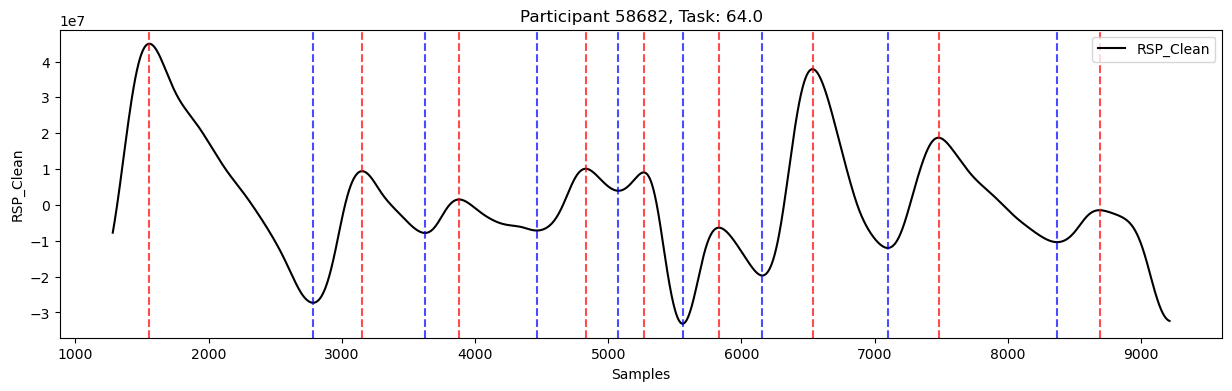

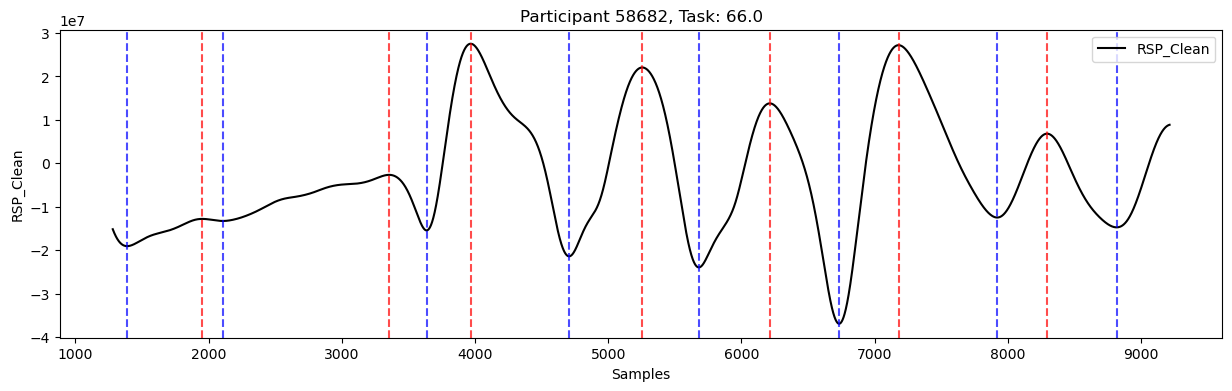

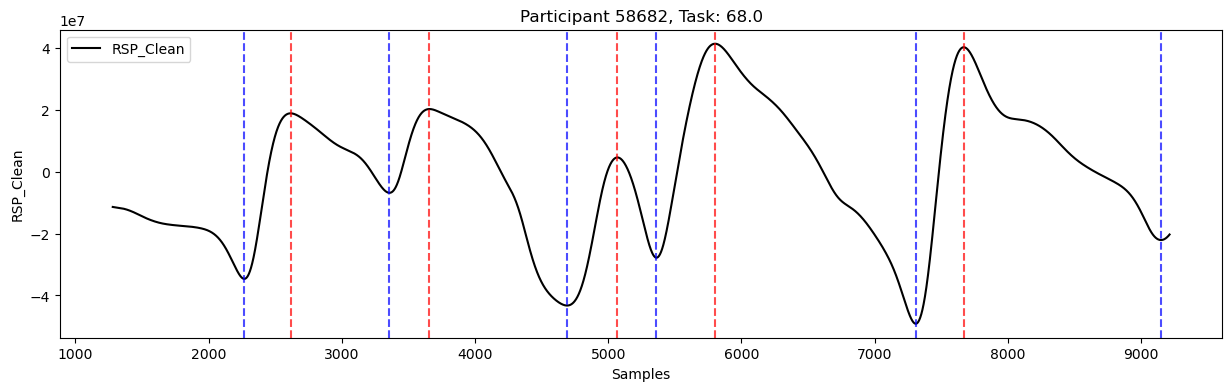

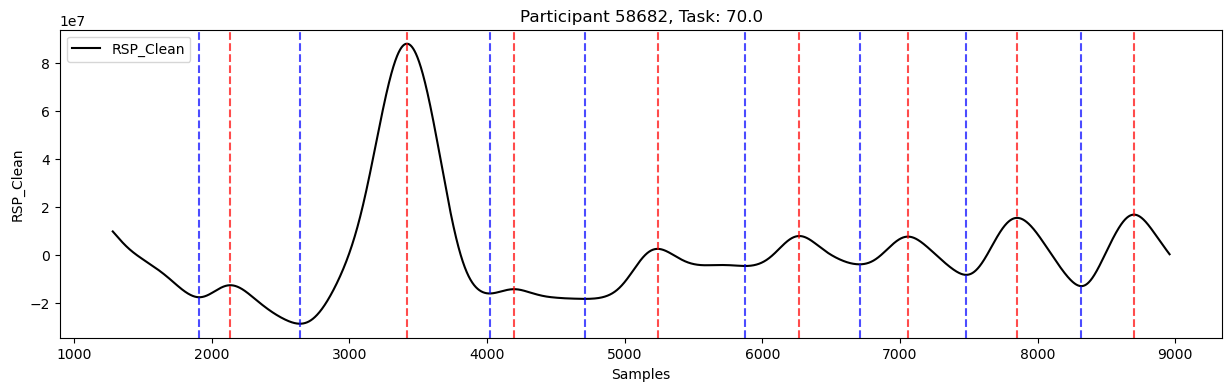

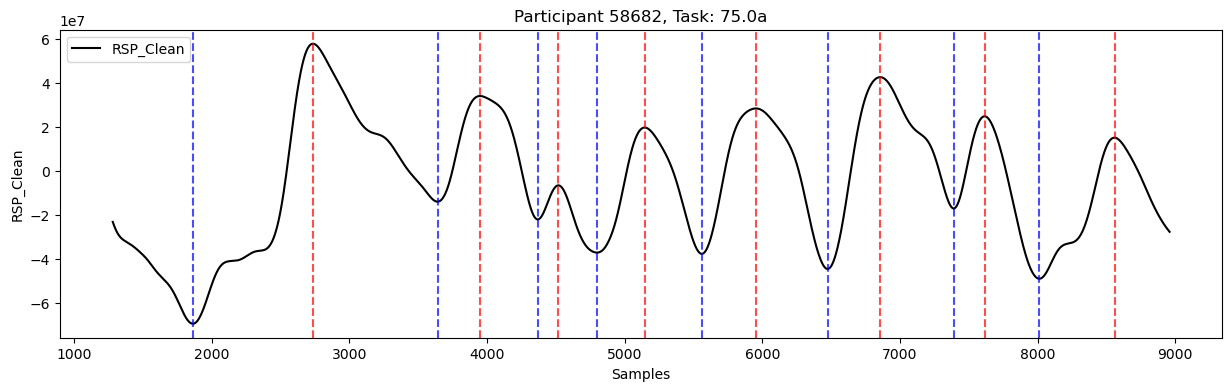

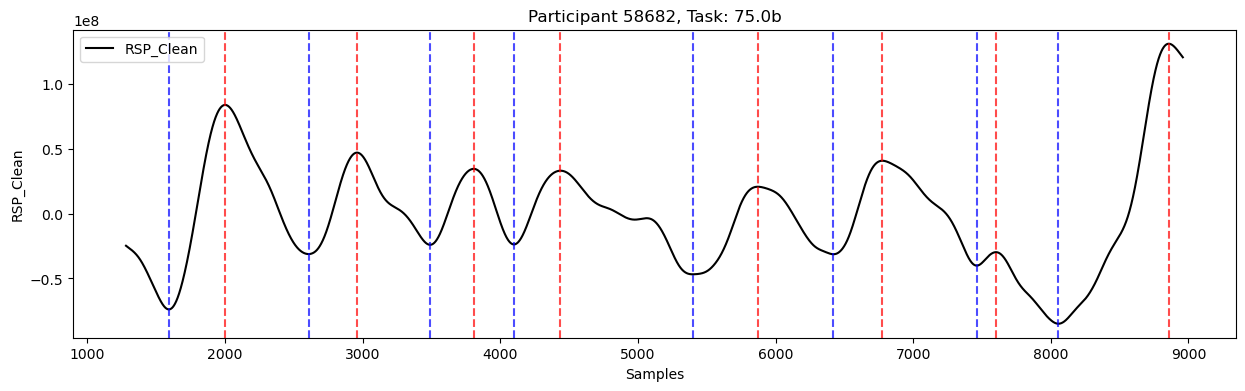

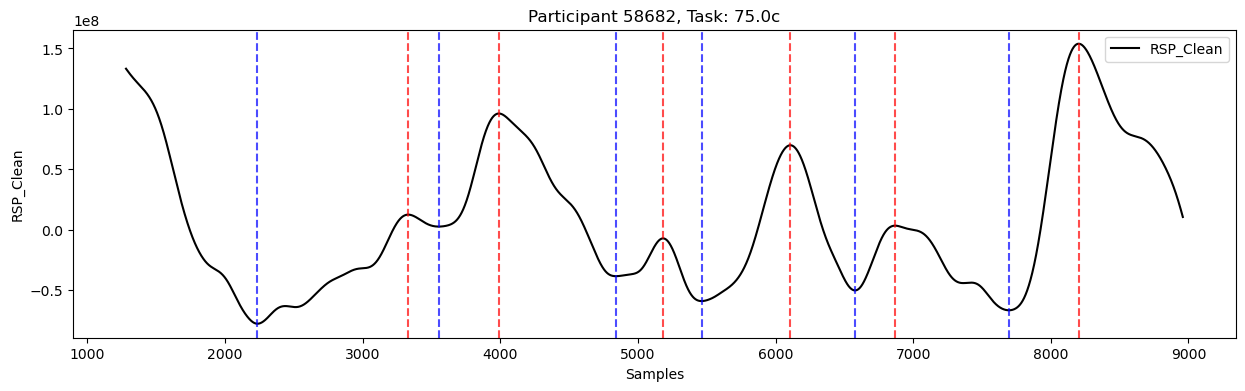

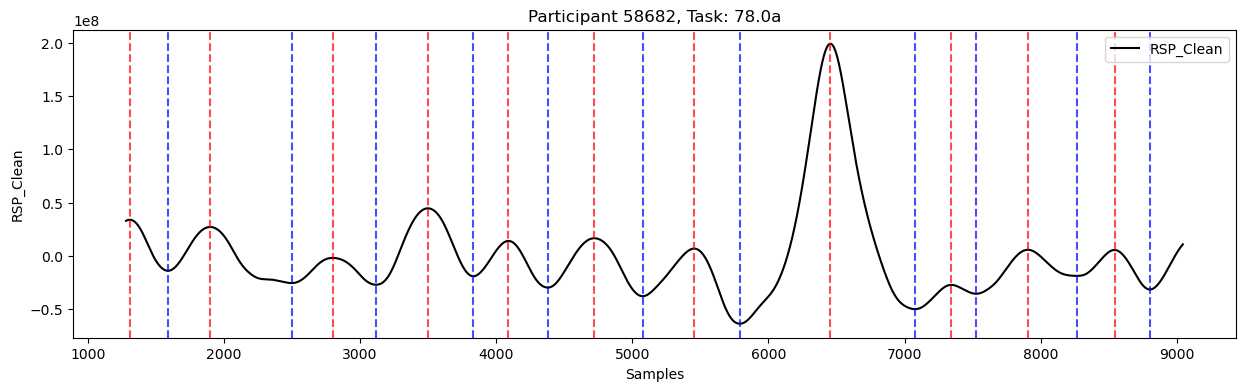

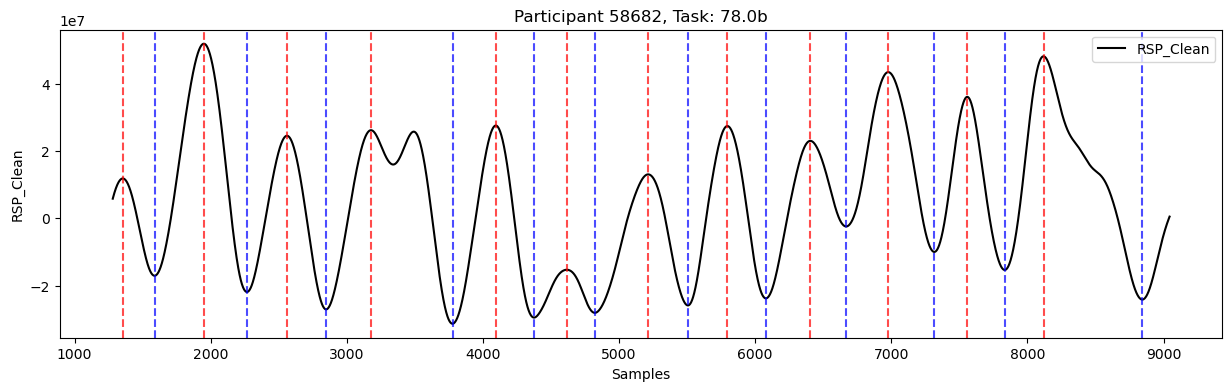

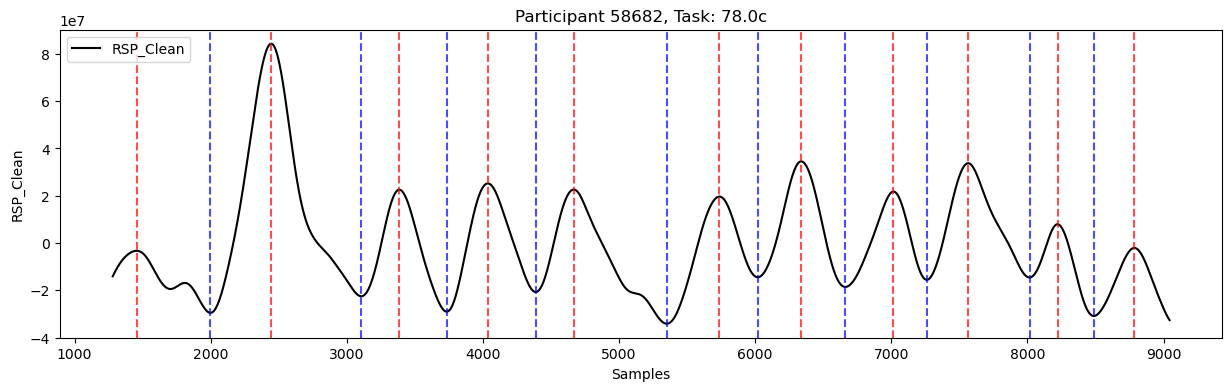

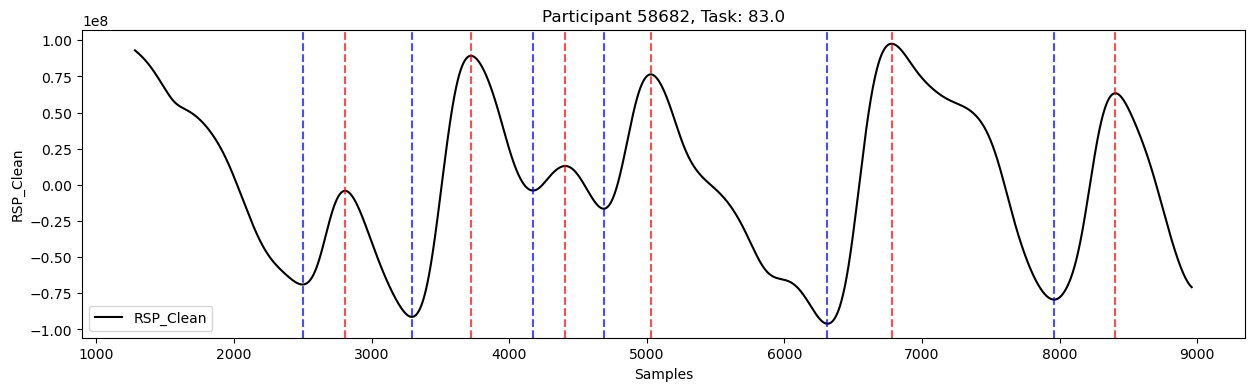

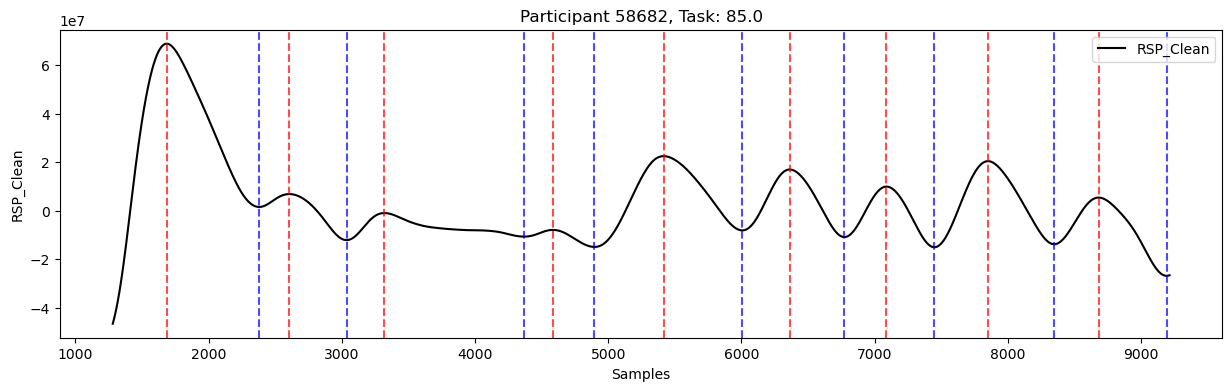

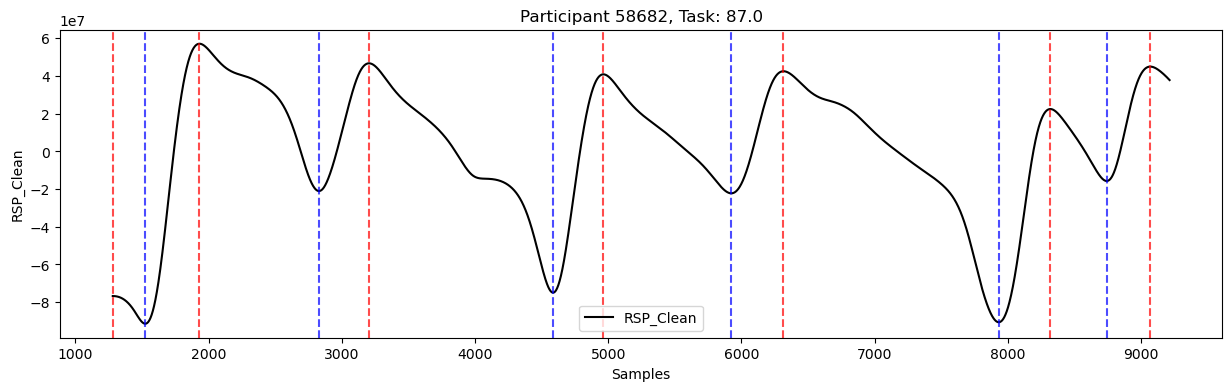

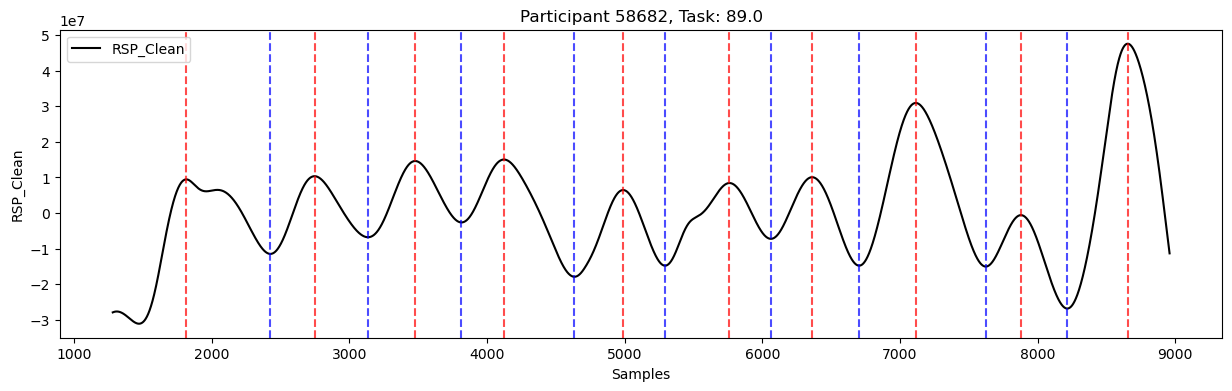

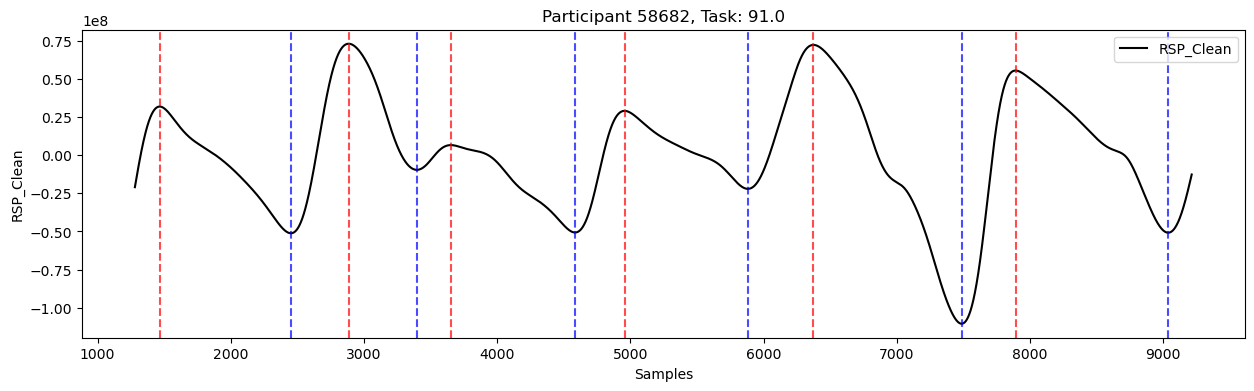

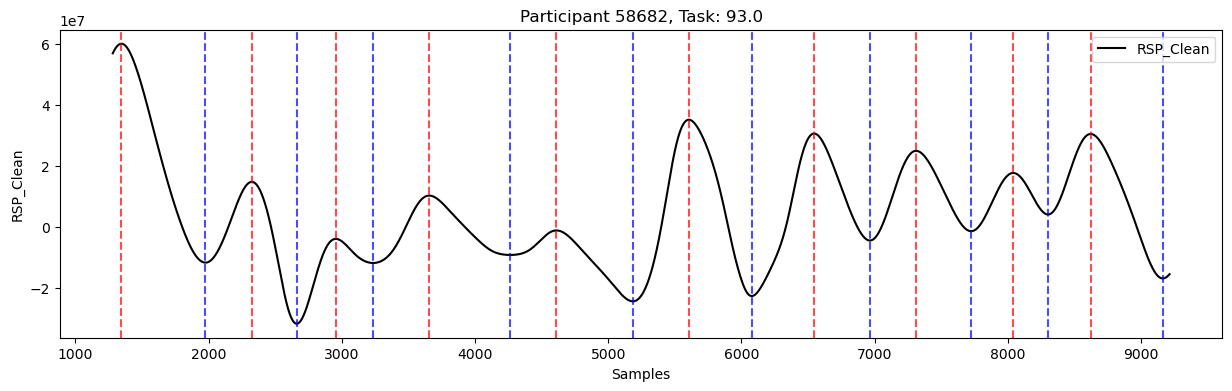

In [5]:
#let's run the function for the dataset we just uploaded
import neurokit2 as nk
import matplotlib.pyplot as plt

tasks = ['12.0a', '12.0b', '12.0c', '12.0d', '12.0e', '12.0f', '14.0a', '14.0b', '14.0c', '14.0d', '14.0e',
         '14.0f', '16.0a', '16.0b', '16.0c', '16.0d', '16.0e', '16.0f', '18.0a', '18.0b', '18.0c', '20.0a',
         '20.0b', '20.0c', '23.0a', '23.0b', '23.0c', '25.0a', '25.0b', '25.0c', '28.0a', '28.0b', '28.0c',
         '30.0a', '30.0b', '30.0c', 34.0, 36.0, 38.0, 40.0, 42.0, 44.0, 47.0, 49.0, 51.0, 53.0, 55.0, 57.0, 60.0,
         62.0, 64.0, 66.0, 68.0, 70.0, '75.0a', '75.0b', '75.0c', '78.0a', '78.0b', '78.0c', 83.0, 85.0, 87.0,
         89.0, 91.0, 93.0]

all_processed_data = {}

all_processed_data = process_and_visualize(df_thorax, tasks)


In [6]:
all_processed_data #contains, for each segment of interest + 5 seconds before and after, the RSP_Clean, RSP_Peaks, RSP_Troughs
#prior to feature extraction, let's double-check the variable contains the dataframes

{'12.0a':             RSP_Raw     RSP_Clean  RSP_Amplitude   RSP_Rate       RSP_RVT  \
 0     -2.388300e+10 -9.483324e+05   3.696041e+07  12.450208  5.279726e+06   
 1     -2.388000e+10 -1.010448e+06   3.696041e+07  12.450208  5.279798e+06   
 2     -2.388300e+10 -1.073143e+06   3.696041e+07  12.450208  5.279921e+06   
 3     -2.388464e+10 -1.136419e+06   3.696041e+07  12.450208  5.280096e+06   
 4     -2.388300e+10 -1.200274e+06   3.696041e+07  12.450208  5.280323e+06   
 ...             ...           ...            ...        ...           ...   
 10235 -2.387303e+10 -1.846042e+04   4.897170e+07  13.161954  1.486134e+06   
 10236 -2.387100e+10 -1.566782e+04   4.897170e+07  13.161954  1.486192e+06   
 10237 -2.386819e+10 -1.317386e+04   4.897170e+07  13.161954  1.486279e+06   
 10238 -2.387100e+10 -1.096205e+04   4.897170e+07  13.161954  1.486393e+06   
 10239 -2.388065e+10 -9.015390e+03   4.897170e+07  13.161954  1.486536e+06   
 
        RSP_Phase  RSP_Phase_Completion  RSP_Symmetry

In [7]:
import numpy as np 
import pandas as pd
#this code extracts features that don't come from neurokit (all features except respiratory rate, RRV, and peak-trough symmtery)
processed_dataframes = all_processed_data
sampling_rate = 256  #if the sampling rate is different for your data, change
task_results = {}
bbb_results = {}

for task, df in processed_dataframes.items():
    print(f"Task: {task}")

    # filter each dataframe for the actual task duration
    task_specific_df = df[df['Task_Label_2'] == task]
    peaks = task_specific_df[task_specific_df['RSP_Peaks'] == 1].index
    troughs = task_specific_df[task_specific_df['RSP_Troughs'] == 1].index

    # combine peaks and troughs into one list and sort
    combined_data = [('Peak', index) for index in peaks] + [('Trough', index) for index in troughs]
    combined_data.sort(key=lambda x: x[1])

    # initialize lists to store durations, amplitudes, flow rates, I:E ratios, and duty cycles
    inspiratory_durations = []
    expiratory_durations = []
    inspiratory_amplitudes = []
    expiratory_amplitudes = []
    inspiratory_flows = []
    expiratory_flows = []
    ie_ratios = []
    duty_cycles = []
    exp_diffs = []

    # iterate through combined data
    for i in range(1, len(combined_data)):
        current_type, current_index = combined_data[i]
        prev_type, prev_index = combined_data[i-1]

        # calculate duration and amplitude
        duration = (current_index - prev_index) / sampling_rate
        amplitude = abs(df.loc[current_index, 'RSP_Clean'] - df.loc[prev_index, 'RSP_Clean'])

        # calculate inspiratory duration, amplitude, and flow rate
        if current_type == 'Peak' and prev_type == 'Trough':
            inspiratory_durations.append(duration)
            inspiratory_amplitudes.append(amplitude)
            if duration > 0:
                inspiratory_flows.append(amplitude / duration)

        # calculate expiratory duration, amplitude, and flow rate
        elif current_type == 'Trough' and prev_type == 'Peak':
            expiratory_durations.append(duration)
            expiratory_amplitudes.append(amplitude)
            if duration > 0:
                expiratory_flows.append(amplitude / duration)
            if inspiratory_durations:
                ie_ratios.append(inspiratory_durations[-1] / duration)
                # Ensure duty cycle is calculated within each breath cycle
                total_cycle_duration = inspiratory_durations[-1] + expiratory_durations[-1]
                duty_cycle = inspiratory_durations[-1] / total_cycle_duration
                duty_cycles.append(duty_cycle)

    # calculate first-order exhalatory differences
    if len(expiratory_durations) > 1:
        exp_diffs = [abs(expiratory_durations[i] - expiratory_durations[i - 1]) for i in range(1, len(expiratory_durations))]

    # calculate mean and SD for durations, amplitudes, flow rates, I:E ratios, and duty cycles
    insp_dur_mean, insp_dur_sd = np.mean(inspiratory_durations), np.std(inspiratory_durations)
    exp_dur_mean, exp_dur_sd = np.mean(expiratory_durations), np.std(expiratory_durations)
    insp_amp_mean, insp_amp_sd = np.mean(inspiratory_amplitudes), np.std(inspiratory_amplitudes)
    exp_amp_mean, exp_amp_sd = np.mean(expiratory_amplitudes), np.std(expiratory_amplitudes)
    insp_flow_mean, insp_flow_sd = np.mean(inspiratory_flows), np.std(inspiratory_flows)
    exp_flow_mean, exp_flow_sd = np.mean(expiratory_flows), np.std(expiratory_flows)
    ie_ratio_mean, ie_ratio_sd = np.mean(ie_ratios), np.std(ie_ratios)
    duty_cycle_mean = np.mean(duty_cycles)
    exp_diff_mean = np.mean(exp_diffs) if exp_diffs else 0

    task_results[task] = {
        'insp_dur_mean': insp_dur_mean,
        'insp_dur_sd': insp_dur_sd,
        'exp_dur_mean': exp_dur_mean,
        'exp_dur_sd': exp_dur_sd,
        'insp_amp_mean': insp_amp_mean,
        'insp_amp_sd': insp_amp_sd,
        'exp_amp_mean': exp_amp_mean,
        'exp_amp_sd': exp_amp_sd,
        'insp_flow_mean': insp_flow_mean,
        'insp_flow_sd': insp_flow_sd,
        'exp_flow_mean': exp_flow_mean,
        'exp_flow_sd': exp_flow_sd,
        'ie_ratio_mean': ie_ratio_mean,
        'ie_ratio_sd': ie_ratio_sd,
        'duty_cycle_mean': duty_cycle_mean,
        'exp_diff_mean': exp_diff_mean
    }

    # store the breath-by-breath results separately
    bbb_results[task] = {
        'inspiratory_durations': inspiratory_durations,
        'expiratory_durations': expiratory_durations,
        'inspiratory_amplitudes': inspiratory_amplitudes,
        'expiratory_amplitudes': expiratory_amplitudes,
        'inspiratory_flows': inspiratory_flows,
        'expiratory_flows': expiratory_flows,
        'ie_ratios': ie_ratios,
        'duty_cycles': duty_cycles,
        'exp_diffs': exp_diffs
    }

# convert the dictionary to a data frame for task_results
respiratory_analysis_df = pd.DataFrame.from_dict(task_results, orient='index')
respiratory_analysis_df.reset_index(inplace=True)
respiratory_analysis_df.rename(columns={'index': 'Task_Label'}, inplace=True)

# create a dataframe for bbb_results
bbb_dataframe = pd.DataFrame.from_dict(bbb_results, orient='index')
bbb_dataframe.reset_index(inplace=True)
bbb_dataframe.rename(columns={'index': 'Task_Label'}, inplace=True)

#display the dataframe containing the features
respiratory_analysis_df


Task: 12.0a
Task: 12.0b
Task: 12.0c
Task: 12.0d
Task: 12.0e
Task: 12.0f
Task: 14.0a
Task: 14.0b
Task: 14.0c
Task: 14.0d
Task: 14.0e
Task: 14.0f
Task: 16.0a
Task: 16.0b
Task: 16.0c
Task: 16.0d
Task: 16.0e
Task: 16.0f
Task: 18.0a
Task: 18.0b
Task: 18.0c
Task: 20.0a
Task: 20.0b
Task: 20.0c
Task: 23.0a
Task: 23.0b
Task: 23.0c
Task: 25.0a
Task: 25.0b
Task: 25.0c
Task: 28.0a
Task: 28.0b
Task: 28.0c
Task: 30.0a
Task: 30.0b
Task: 30.0c
Task: 34.0
Task: 36.0
Task: 38.0
Task: 40.0
Task: 42.0
Task: 44.0
Task: 47.0
Task: 49.0
Task: 51.0
Task: 53.0
Task: 55.0
Task: 57.0
Task: 60.0
Task: 62.0
Task: 64.0
Task: 66.0
Task: 68.0
Task: 70.0
Task: 75.0a
Task: 75.0b
Task: 75.0c
Task: 78.0a
Task: 78.0b
Task: 78.0c
Task: 83.0
Task: 85.0
Task: 87.0
Task: 89.0
Task: 91.0
Task: 93.0


Task_Label  insp_dur_mean  insp_dur_sd  exp_dur_mean  exp_dur_sd  \
0       12.0a       2.119531     0.148491      2.697917    0.366561   
1       12.0b       1.784040     0.637366      1.936035    0.415648   
2       12.0c       1.743304     0.306376      2.152902    0.254711   
3       12.0d       1.510417     0.130961      1.767578    0.199171   
4       12.0e       1.489149     0.241330      1.780762    0.309799   
..        ...            ...          ...           ...         ...   
61       85.0       1.295898     0.358795      2.106771    0.825020   
62       87.0       1.476562     0.097552      3.593750    1.891396   
63       89.0       1.390191     0.258649      1.578993    0.410128   
64       91.0       1.530469     0.306728      3.654297    0.808920   
65       93.0       1.424479     0.215076      1.772266    0.496620   

    insp_amp_mean   insp_amp_sd  exp_amp_mean    exp_amp_sd  insp_flow_mean  \
0    4.851416e+07  6.724510e+06  5.912317e+07  2.948060e+07    2.290179e+07   
1    3.626525e+07  2.352280e+07  3.731184e+07  1.846227e+07    1.885214e+07   
2    3.903859e+07  7.699237e+06  3.955112e+07  7.972358e+06    2.234677e+07   
3    3.498486e+07  4.815796e+06  3.537913e+07  2.948878e+06    2.312015e+07   
4    3.397062e+07  1.024971e+07  3.513753e+07  8.350885e+06    2.257661e+07   
..            ...           ...           ...           ...             ...   
61   1.965830e+07  1.203975e+07  2.810086e+07  1.656862e+07    1.375440e+07   
62   9.514012e+07  3.282155e+07  7.484704e+07  4.225059e+07    6.375755e+07   
63   2.890130e+07  1.817945e+07  2.467103e+07  9.071270e+06    1.989932e+07   
64   9.619909e+07  4.969006e+07  9.396246e+07  4.375483e+07    5.973585e+07   
65   3.020398e+07  1.528790e+07  3.486974e+07  1.948170e+07    2.072012e+07   

    insp_flow_sd  exp_flow_mean   exp_flow_sd  ie_ratio_mean  ie_ratio_sd  \
0   2.906709e+06   2.107687e+07  7.262757e+06       0.833592     0.089998   
1   9.093636e+06   1.813684e+07  7.270037e+06       0.941216     0.223992   
2   1.741486e+06   1.826199e+07  2.277082e+06       0.833857     0.120296   
3   1.970526e+06   2.018669e+07  2.185042e+06       0.865044     0.070907   
4   3.819249e+06   1.979880e+07  3.425867e+06       0.841097     0.053128   
..           ...            ...           ...            ...          ...   
61  6.241658e+06   1.405019e+07  6.424174e+06       0.697497     0.200304   
62  1.936472e+07   2.023969e+07  2.952525e+06       0.455877     0.243319   
63  9.309005e+06   1.583809e+07  4.305007e+06       0.952442     0.275894   
64  2.919311e+07   2.645955e+07  1.128022e+07       0.463965     0.199779   
65  8.323436e+06   1.948498e+07  9.504723e+06       0.892203     0.214227   

    duty_cycle_mean  exp_diff_mean  
0          0.453392       0.411719  
1          0.478614       0.437500  
2          0.452465       0.358724  
3          0.463045       0.136719  
4          0.456382       0.257812  
..              ...            ...  
61         0.401285       1.113770  
62         0.296430       2.664844  
63         0.478542       0.508301  
64         0.305738       0.873437  
65         0.464518       0.567274  

[66 rows x 17 columns]

In [8]:
#we also need to add the features from neurokit2's function, below we run the intervalrelated function of neurokit2

import pandas as pd
import neurokit2 as nk

tasks = ['12.0a', '12.0b', '12.0c', '12.0d', '12.0e', '12.0f', '14.0a', '14.0b', '14.0c', '14.0d', '14.0e',
         '14.0f', '16.0a', '16.0b', '16.0c', '16.0d', '16.0e', '16.0f', '18.0a', '18.0b', '18.0c', '20.0a',
         '20.0b', '20.0c', '23.0a', '23.0b', '23.0c', '25.0a', '25.0b', '25.0c', '28.0a', '28.0b', '28.0c',
         '30.0a', '30.0b', '30.0c', 34.0, 36.0, 38.0, 40.0, 42.0, 44.0, 47.0, 49.0, 51.0, 53.0, 55.0, 57.0, 60.0,
         62.0, 64.0, 66.0, 68.0, 70.0, '75.0a', '75.0b', '75.0c', '78.0a', '78.0b', '78.0c', 83.0, 85.0, 87.0,
         89.0, 91.0, 93.0]

processed_dataframes = all_processed_data

# initializing empty list
interval_features_list = []

# iterating over task dataframes
for task, df in processed_dataframes.items():
    try:
        # filtering the dataframe for the actual task duration
        task_specific_df = df[df['Task_Label_2'] == task]

        # extracting interval-related features
        features_df = nk.rsp_intervalrelated(task_specific_df, sampling_rate=256)

        # adding a column for the task label
        features_df['Task_Label'] = task

        # appending the features DataFrame to the list
        interval_features_list.append(features_df)
    except Exception as e:
        print(f"Error processing task {task}: {e}")

# concatenating all feature dataframes
interval_features_df = pd.concat(interval_features_list, ignore_index=True)
interval_features_df

C:\Users\msa583\AppData\Local\anaconda3\lib\site-packages\neurokit2\rsp\rsp_rrv.py:213: RuntimeWarning: invalid value encountered in sqrt
  out["SD2"] = np.sqrt(2 * np.std(bbi, ddof=1) ** 2 - 0.5 * np.std(diff_bbi, ddof=1) ** 2)
C:\Users\msa583\AppData\Local\anaconda3\lib\site-packages\neurokit2\rsp\rsp_rrv.py:213: RuntimeWarning: invalid value encountered in sqrt
  out["SD2"] = np.sqrt(2 * np.std(bbi, ddof=1) ** 2 - 0.5 * np.std(diff_bbi, ddof=1) ** 2)
C:\Users\msa583\AppData\Local\anaconda3\lib\site-packages\neurokit2\rsp\rsp_rrv.py:213: RuntimeWarning: invalid value encountered in sqrt
  out["SD2"] = np.sqrt(2 * np.std(bbi, ddof=1) ** 2 - 0.5 * np.std(diff_bbi, ddof=1) ** 2)


RSP_Rate_Mean    RRV_RMSSD   RRV_MeanBB     RRV_SDBB     RRV_SDSD  \
0       12.321747   426.492919  4678.125000   310.400663   489.850343   
1       16.388246  1825.740465  3643.973214  1043.891087  1981.159735   
2       15.537547   933.649318  3882.161458   565.429744  1040.548309   
3       17.417863   364.231069  3287.597656   330.758047   373.705370   
4       18.542579   690.382426  3272.949219   593.729578   743.258254   
..            ...          ...          ...          ...          ...   
61      17.685187  1877.871104  3327.148438  1022.957626  2025.198460   
62      12.233052  2938.933976  5639.843750  1798.802465  3347.744181   
63      19.546314   754.885790  2827.148438   419.365417   812.314414   
64      11.710990   800.395296  5146.093750  1055.185068   624.731388   
65      18.664205   831.711399  3119.791667   621.876350   884.323428   

    RRV_CVBB  RRV_CVSD  RRV_MedianBB    RRV_MadBB  RRV_MCVBB  ...  \
0   0.066352  0.091167   4589.843750    98.453906   0.021450  ...   
1   0.286471  0.501030   3582.031250   527.017969   0.147128  ...   
2   0.145648  0.240497   3771.484375   503.852344   0.133595  ...   
3   0.100608  0.110789   3289.062500   428.564062   0.130300  ...   
4   0.181405  0.210936   3121.093750   359.067187   0.115045  ...   
..       ...       ...           ...          ...        ...  ...   
61  0.307458  0.564409   3144.531250   802.109766   0.255081  ...   
62  0.318945  0.521102   5226.562500  2432.390625   0.465390  ...   
63  0.148335  0.267013   2712.890625   370.650000   0.136625  ...   
64  0.205046  0.155535   5070.312500  1459.434375   0.287839  ...   
65  0.199333  0.266592   3367.187500   590.723437   0.175435  ...   

          RAV_SD     RAV_RMSSD  RAV_CVSD       RSP_RVT  \
0   3.718358e+07  4.330668e+07  0.682597  1.171066e+07   
1   2.359925e+07  3.717465e+07  1.006453  9.767230e+06   
2   8.779160e+06  1.436009e+07  0.354307  9.782740e+06   
3   5.107923e+06  7.406028e+06  0.211692  9.989592e+06   
4   1.087146e+07  1.615941e+07  0.475688  1.034049e+07   
..           ...           ...       ...           ...   
61  3.625784e+07  4.419799e+07  1.423057  6.572803e+06   
62  4.670096e+07  7.800284e+07  0.944536  1.140311e+07   
63  1.890134e+07  2.584196e+07  0.846240  8.903487e+06   
64  5.042612e+07  6.500844e+07  0.652017  1.423848e+07   
65  2.858670e+07  3.344464e+07  0.883784  8.512865e+06   

    RSP_Symmetry_PeakTrough  RSP_Symmetry_RiseDecay  \
0                  0.558228                0.456419   
1                  0.495707                0.470945   
2                  0.500752                0.452569   
3                  0.517252                0.458689   
4                  0.488968                0.457618   
..                      ...                     ...   
61                 0.521720                0.398208   
62                 0.396910                0.306632   
63                 0.492202                0.484182   
64                 0.455989                0.306928   
65                 0.525078                0.463715   

    RSP_Phase_Duration_Inspiration  RSP_Phase_Duration_Expiration  \
0                         2.115625                       2.694010   
1                         1.780134                       1.932129   
2                         1.739397                       2.148996   
3                         1.506510                       1.763672   
4                         1.485243                       1.776855   
..                             ...                            ...   
61                        1.291992                       2.102865   
62                        1.472656                       3.589844   
63                        1.386285                       1.575087   
64                        1.526563                       3.650391   
65                        1.420573                       1.768359   

    RSP_Phase_Duration_Ratio  Task_Label  
0                   0.785307       12.0a  
1                   0.921

In [9]:
import pandas as pd

#let's add the three features we need from neurokit into the previous dataframe of features

selected_columns = interval_features_df[['Task_Label', 'RSP_Symmetry_PeakTrough', 'RRV_RMSSD', 'RSP_Rate_Mean']]

respiratory_analysis_df_2 = pd.merge(respiratory_analysis_df, selected_columns, on='Task_Label', how='left')

In [10]:
# Checking if there are any missing values
missing_values = respiratory_analysis_df_2.isnull().sum()

print("Missing values in respiratory_analysis_df_2:")
print(missing_values)

for column in respiratory_analysis_df_2.columns:
    if column != 'Task_Label' and missing_values[column] > 0:
        missing_task_label_values = respiratory_analysis_df_2[respiratory_analysis_df_2[column].isnull()]['Task_Label']
        print(f"Missing values in '{column}' column. Corresponding values in 'Task_Label' column:")
        print(missing_task_label_values)



Missing values in respiratory_analysis_df_2:
Task_Label                 0
insp_dur_mean              0
insp_dur_sd                0
exp_dur_mean               0
exp_dur_sd                 0
insp_amp_mean              0
insp_amp_sd                0
exp_amp_mean               0
exp_amp_sd                 0
insp_flow_mean             0
insp_flow_sd               0
exp_flow_mean              0
exp_flow_sd                0
ie_ratio_mean              0
ie_ratio_sd                0
duty_cycle_mean            0
exp_diff_mean              0
RSP_Symmetry_PeakTrough    0
RRV_RMSSD                  0
RSP_Rate_Mean              0
dtype: int64


In [ ]:
#Run this cell if there is a missing value: THIS IMPUTES FOR THE MISSING VALUES OF RR, RMSSD, PEAK TROUGH with the average of
#the individual's all other values for the feature
#If there are no missing values, you may skip this cell

import pandas as pd
from sklearn.impute import SimpleImputer

task_label_column = respiratory_analysis_df_2['Task_Label']

data_for_imputation = respiratory_analysis_df_2.drop(columns=['Task_Label'])

# creating an instance of SimpleImputer with the mean strategy
imputer = SimpleImputer(strategy='mean')

# applying the imputer to the data frame (excluding 'Task_Label' column)
imputed_data = pd.DataFrame(imputer.fit_transform(data_for_imputation), columns=data_for_imputation.columns)

# concatenating the imputed data with the 'Task_Label' column
respiratory_analysis_df_2 = pd.concat([task_label_column, imputed_data], axis=1)

# Print the DataFrame with imputed values
print("DataFrame with imputed values:")
print(respiratory_analysis_df_2)

In [11]:
# We add the inspiratory minute depth (or volume) by multiplying the mean inspiratory depth with the mean respiratory rate
respiratory_analysis_df_2['insp_minu_depth'] = respiratory_analysis_df_2['insp_amp_mean'] * respiratory_analysis_df_2['RSP_Rate_Mean']

#Repeat of expiratory minute depth
respiratory_analysis_df_2['exp_minu_depth'] = respiratory_analysis_df_2['exp_amp_mean'] * respiratory_analysis_df_2['RSP_Rate_Mean']

respiratory_analysis_df_2

#if wanted, we can add a new column with the participant number
#respiratory_analysis_df_2['Participant'] = 53522

Task_Label  insp_dur_mean  insp_dur_sd  exp_dur_mean  exp_dur_sd  \
0       12.0a       2.119531     0.148491      2.697917    0.366561   
1       12.0b       1.784040     0.637366      1.936035    0.415648   
2       12.0c       1.743304     0.306376      2.152902    0.254711   
3       12.0d       1.510417     0.130961      1.767578    0.199171   
4       12.0e       1.489149     0.241330      1.780762    0.309799   
..        ...            ...          ...           ...         ...   
61       85.0       1.295898     0.358795      2.106771    0.825020   
62       87.0       1.476562     0.097552      3.593750    1.891396   
63       89.0       1.390191     0.258649      1.578993    0.410128   
64       91.0       1.530469     0.306728      3.654297    0.808920   
65       93.0       1.424479     0.215076      1.772266    0.496620   

    insp_amp_mean   insp_amp_sd  exp_amp_mean    exp_amp_sd  insp_flow_mean  \
0    4.851416e+07  6.724510e+06  5.912317e+07  2.948060e+07    2.290179e+07   
1    3.626525e+07  2.352280e+07  3.731184e+07  1.846227e+07    1.885214e+07   
2    3.903859e+07  7.699237e+06  3.955112e+07  7.972358e+06    2.234677e+07   
3    3.498486e+07  4.815796e+06  3.537913e+07  2.948878e+06    2.312015e+07   
4    3.397062e+07  1.024971e+07  3.513753e+07  8.350885e+06    2.257661e+07   
..            ...           ...           ...           ...             ...   
61   1.965830e+07  1.203975e+07  2.810086e+07  1.656862e+07    1.375440e+07   
62   9.514012e+07  3.282155e+07  7.484704e+07  4.225059e+07    6.375755e+07   
63   2.890130e+07  1.817945e+07  2.467103e+07  9.071270e+06    1.989932e+07   
64   9.619909e+07  4.969006e+07  9.396246e+07  4.375483e+07    5.973585e+07   
65   3.020398e+07  1.528790e+07  3.486974e+07  1.948170e+07    2.072012e+07   

    ...   exp_flow_sd  ie_ratio_mean  ie_ratio_sd  duty_cycle_mean  \
0   ...  7.262757e+06       0.833592     0.089998         0.453392   
1   ...  7.270037e+06       0.941216     0.223992         0.478614   
2   ...  2.277082e+06       0.833857     0.120296         0.452465   
3   ...  2.185042e+06       0.865044     0.070907         0.463045   
4   ...  3.425867e+06       0.841097     0.053128         0.456382   
..  ...           ...            ...          ...              ...   
61  ...  6.424174e+06       0.697497     0.200304         0.401285   
62  ...  2.952525e+06       0.455877     0.243319         0.296430   
63  ...  4.305007e+06       0.952442     0.275894         0.478542   
64  ...  1.128022e+07       0.463965     0.199779         0.305738   
65  ...  9.504723e+06       0.892203     0.214227         0.464518   

    exp_diff_mean  RSP_Symmetry_PeakTrough    RRV_RMSSD  RSP_Rate_Mean  \
0        0.411719                 0.558228   426.492919      12.321747   
1        0.437500                 0.495707  1825.740465      16.388246   
2        0.358724                 0.500752   933.649318      15.537547   
3        0.136719                 0.517252   364.231069      17.417863   
4        0.257812                 0.488968   690.382426      18.542579   
..            ...                      ...          ...            ...   
61       1.113770                 0.521720  1877.871104      17.685187   
62       2.664844                 0.396910  2938.933976      12.233052   
63       0.508301                 0.492202   754.885790      19.546314   
64       0.873437                 0.455989   800.395296      11.710990   
65       0.567274                 0.525078   831.711399      18.664205   

    insp_minu_depth  exp_minu_depth  
0      5.977792e+08    7.285007e+08  
1      5.943238e+08    6.114756e+08  
2      6.065639e+08    6.145274e+08  
3      6.093615e+08    6.162288e+08  
4      6.299030e+08    6.515404e+08  
..              ...             ...  
61     3.476608e+08    4.969689e+08  
62     1.163854e+09    9.156077e+08  
63     5.649138e+08    4.822277e+08  
64     1.126587e+09    1.100393e+09  
65     5.637333e+08    6.508160e+08  

[66 rows x 22 

In [ ]:
#Extract the dataframe as en Excel file

import pandas as pd

writer = pd.ExcelWriter('features_hexoskin_58682_thorax.xlsx', engine='xlsxwriter')

respiratory_analysis_df_2.to_excel(writer, index=False, float_format='%.7f', sheet_name='Sheet1')

writer.save()